In [49]:
import argparse
import os
import random

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib.animation as animation
# from IPython.display import HTML

# signal processing
from scipy import signal
import pywt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [50]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 32

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [90]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# probability of augmenting data
aug_p = 0.5

# y-axis processing
distance = 3.086e22
gw_df = gw_df / distance

gw_mean = gw_df.mean().mean()
print('Dataset mean: ',  gw_mean)

gw_std = gw_df.std().std()
print('Dataset std: ',  gw_std)

/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_87518/577045715.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  augmented_signal = np.roll(signal, int(shift))


torch.Size([32, 1, 512])


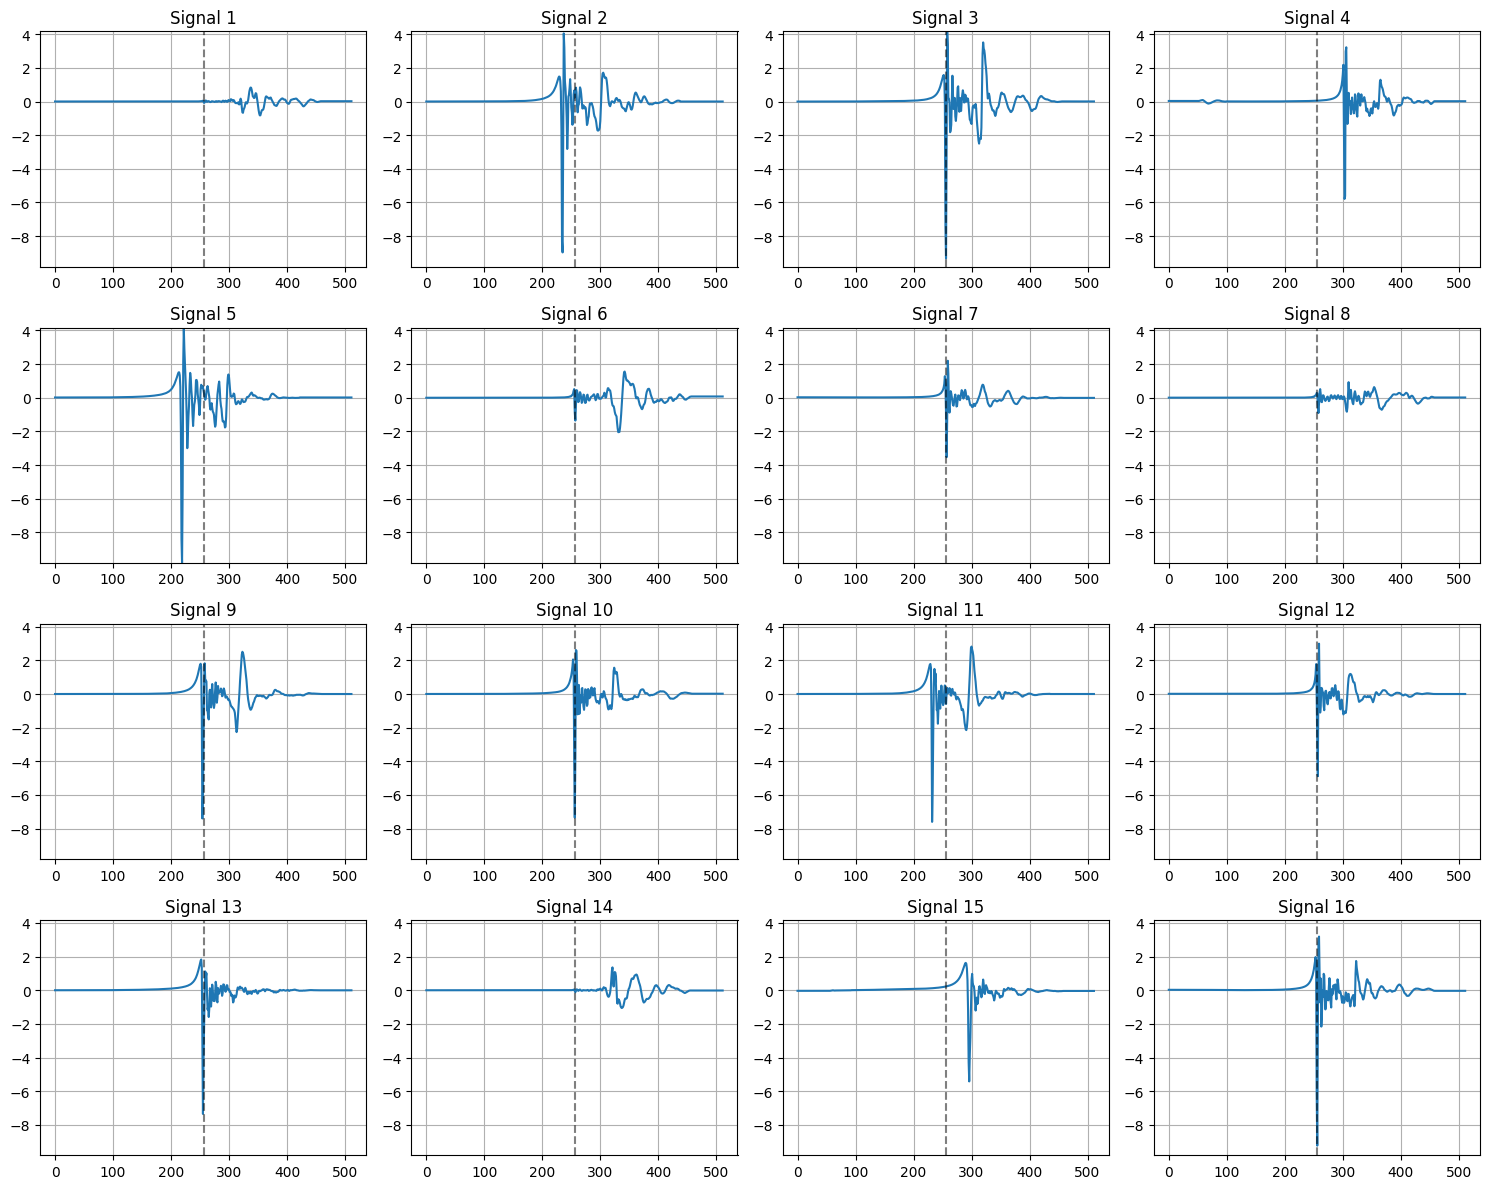

In [91]:
def standardize(dataset):
        standardized_signal = (dataset - gw_mean) / gw_std
        standardized_signal = standardized_signal / 5
        return standardized_signal

class GWDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).astype('float32')
        self.data = self.data.values

    def shift_augmentation(self):
        augmented_signals = self.data.copy()
        
        for i in range(self.data.shape[1]):
            rand = np.random.random()
            if (rand < aug_p):
                signal = self.data[:, i]
                signal = signal.reshape(1, -1)

                shift = np.random.normal(0, 50, 1)
                augmented_signal = np.roll(signal, int(shift))
                augmented_signals = np.insert(augmented_signals, i, augmented_signal, axis=1)

        self.data = augmented_signals

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        # process signal from strain * distance (10 kpc) -> just strain
        distance = 3.086e22
        signal = signal / distance

        # reshape signal to have first 512 - 407 values to be 0.
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = standardize(signal_padded)

        return signal_standardized

dataset = GWDataset("../data/gw-raw-data/richers_1764.csv")
dataset.shift_augmentation()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))

# Expecting: (32, 1, 512)
print(real_batch.shape)

common_ylim = (real_batch[:,:,:].min(), real_batch[:,:,:].max())

def plot_and_save_waveforms(real_batch, filename='waveforms.png'):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_batch.size(dim=2))
        y = real_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)
    
    for i in range(512, 8*4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)  # Save the plot to a PNG file
    
    plt.show()

# Example usage: Display and save the plot to 'waveforms.png'
plot_and_save_waveforms(real_batch, filename='../data/gw-dcgans-plots/real_data.png')

In [83]:
dataset.__len__()

2623

### Weight Initialisation (Random Noise)

In [54]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [55]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [56]:
# # Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(300, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [57]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False),
            )

            # fully conencted layer to output probability
            self.fc = nn.Sequential(
                nn.Dropout(0.25),
                nn.Sigmoid()
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            # print(x)
            return x

elif (gans_type == "wgans"):
    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            # x = self.fc(x)
            # print(x)
            return x

In [58]:
if (gans_type == "dcgans"):
    netD = Discriminator().to(device)
    netD.apply(weights_init)

    print(netD)

    model = Discriminator()
    summary(model, input_size=(1, 512))

elif (gans_type == "wgans"):
    netC = Critic().to(device)
    netC.apply(weights_init)

    print(netC)

    model = Critic()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.25, inp

### Loss functions and Optimisers

In [59]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Starting Training Loop...
[0/32][0/111]	Loss_D: 2.0281	Loss_G: 0.7955	D(x): 0.3503	D(G(z)): 0.3985 / 0.3958
[0/32][50/111]	Loss_D: 1.0404	Loss_G: 2.6292	D(x): 0.1856	D(G(z)): 0.6869 / 0.7018
[0/32][100/111]	Loss_D: 0.8349	Loss_G: 2.2097	D(x): 0.1090	D(G(z)): 0.7351 / 0.6461


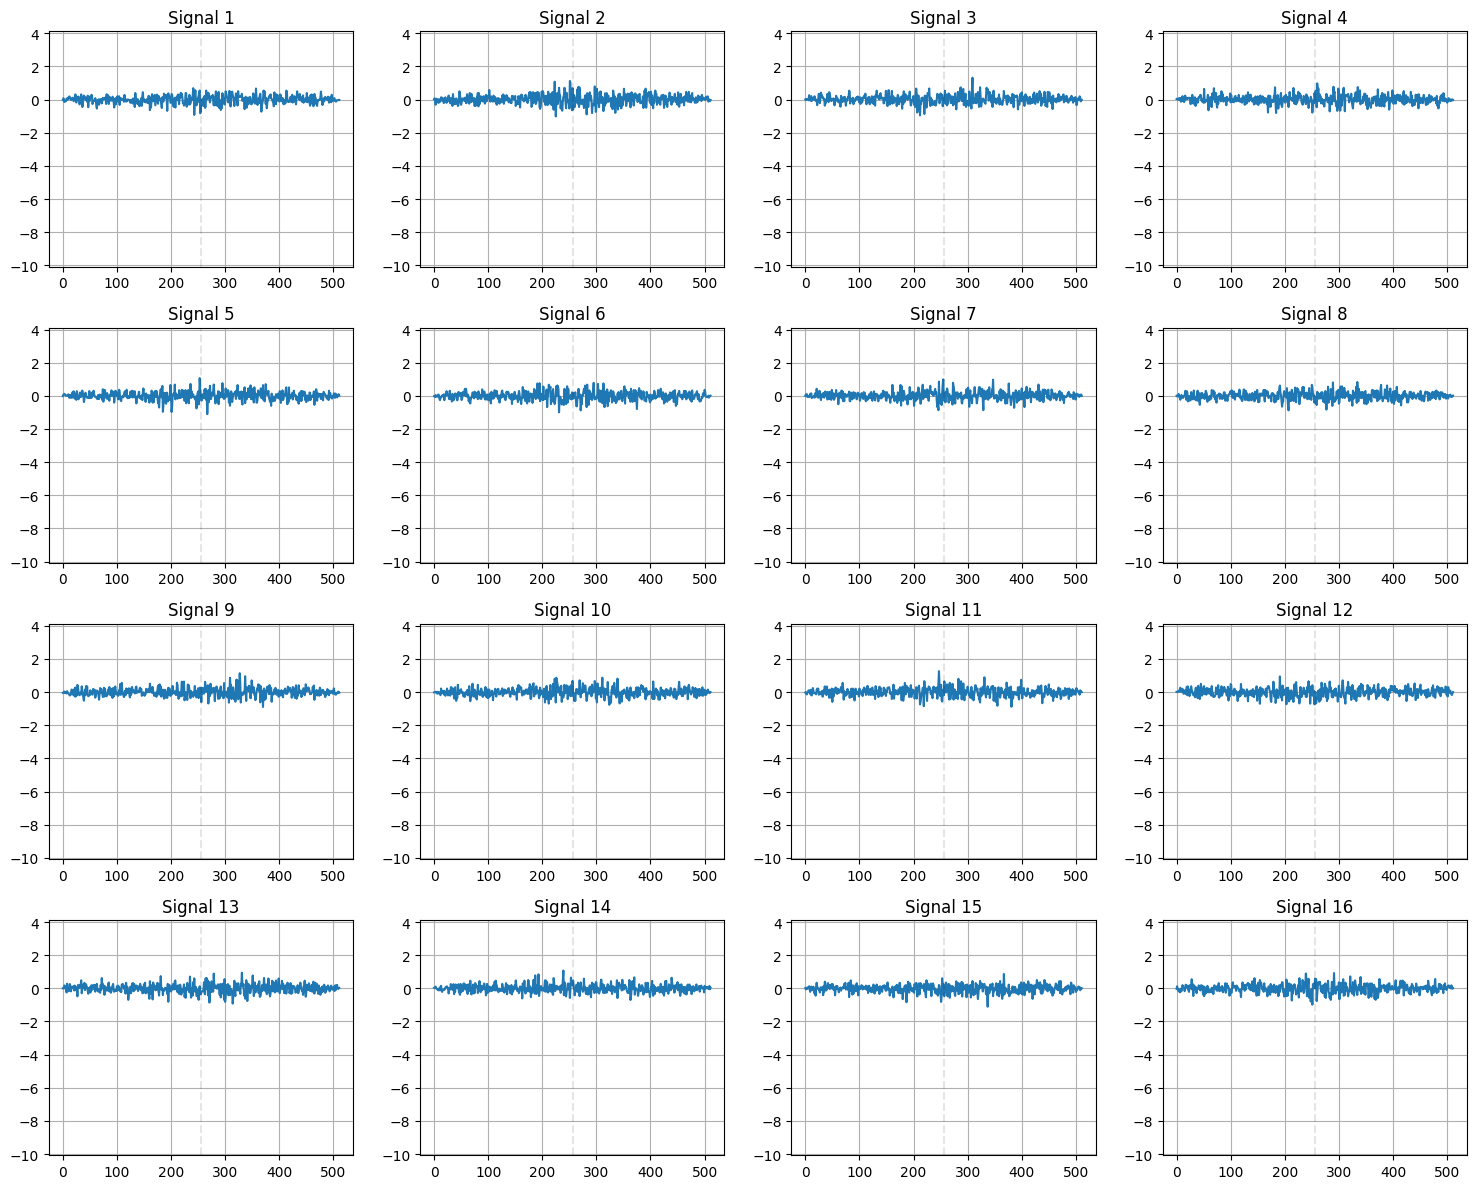

[1/32][0/111]	Loss_D: 1.0393	Loss_G: 3.2114	D(x): 0.1991	D(G(z)): 0.8114 / 0.7610
[1/32][50/111]	Loss_D: 0.9178	Loss_G: 2.5573	D(x): 0.1211	D(G(z)): 0.7891 / 0.7489
[1/32][100/111]	Loss_D: 0.9191	Loss_G: 2.6925	D(x): 0.1436	D(G(z)): 0.6847 / 0.6697


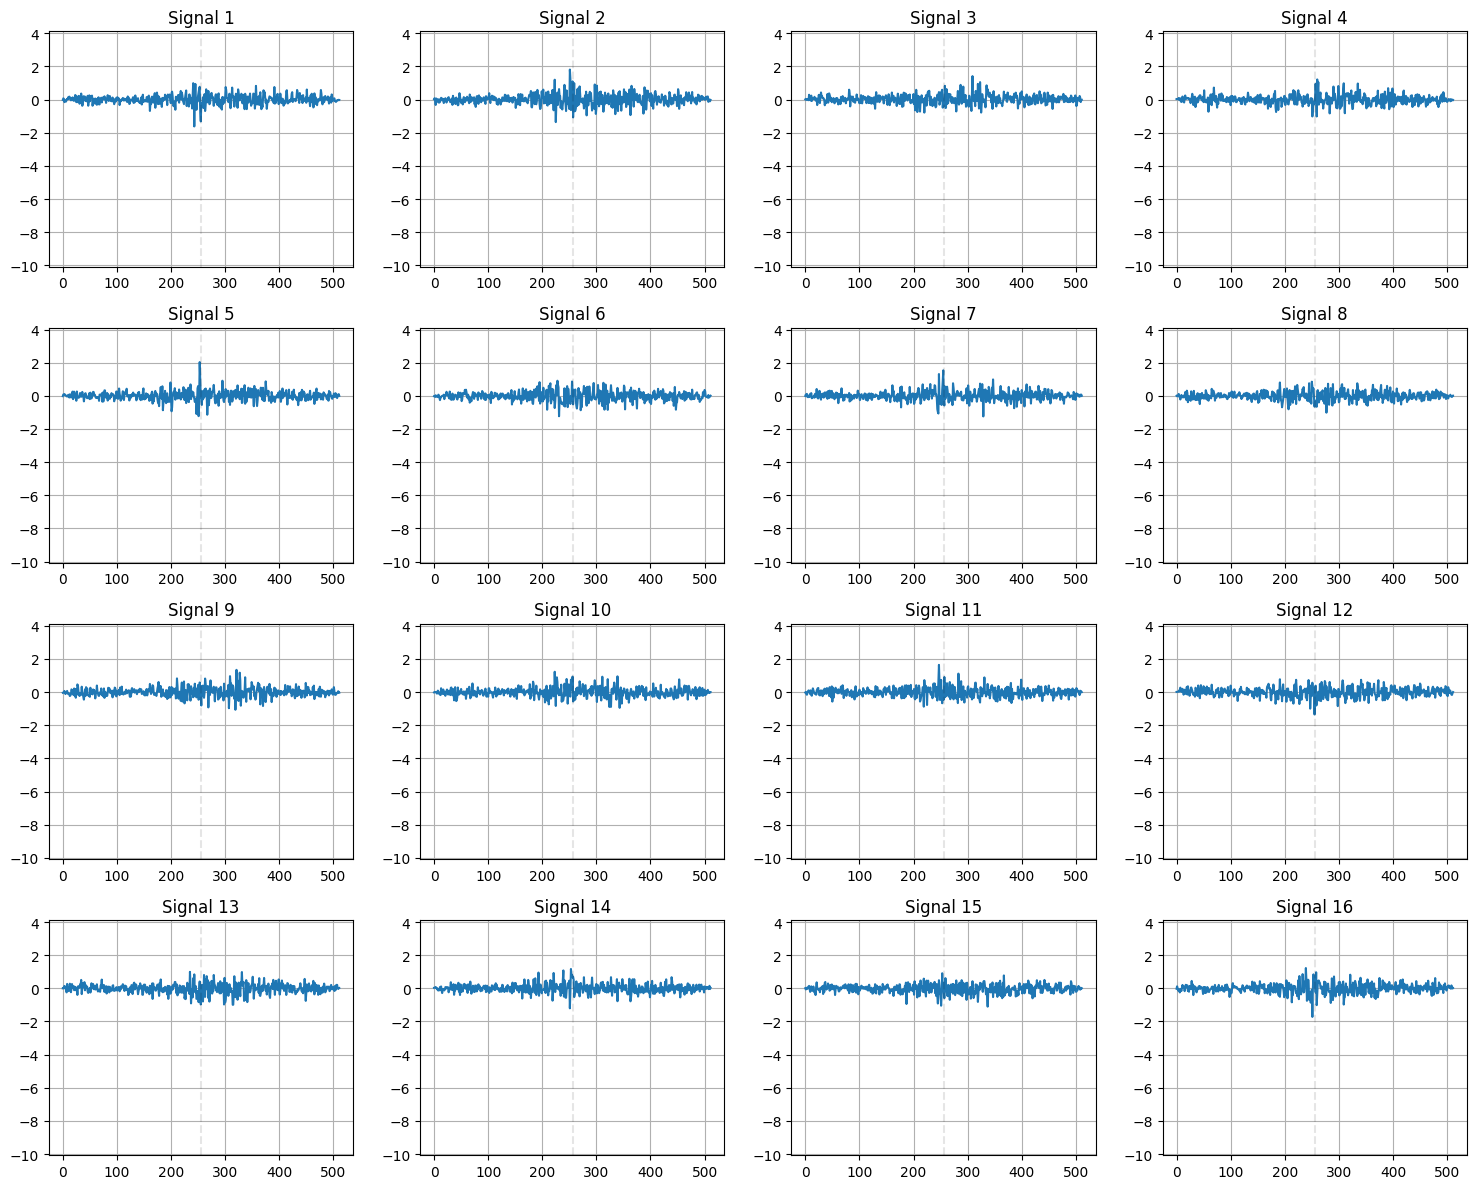

[2/32][0/111]	Loss_D: 0.8957	Loss_G: 1.7842	D(x): 0.1570	D(G(z)): 0.6224 / 0.6584
[2/32][50/111]	Loss_D: 0.8679	Loss_G: 1.9439	D(x): 0.1613	D(G(z)): 0.7204 / 0.7099
[2/32][100/111]	Loss_D: 0.8527	Loss_G: 2.2418	D(x): 0.1215	D(G(z)): 0.6777 / 0.7338


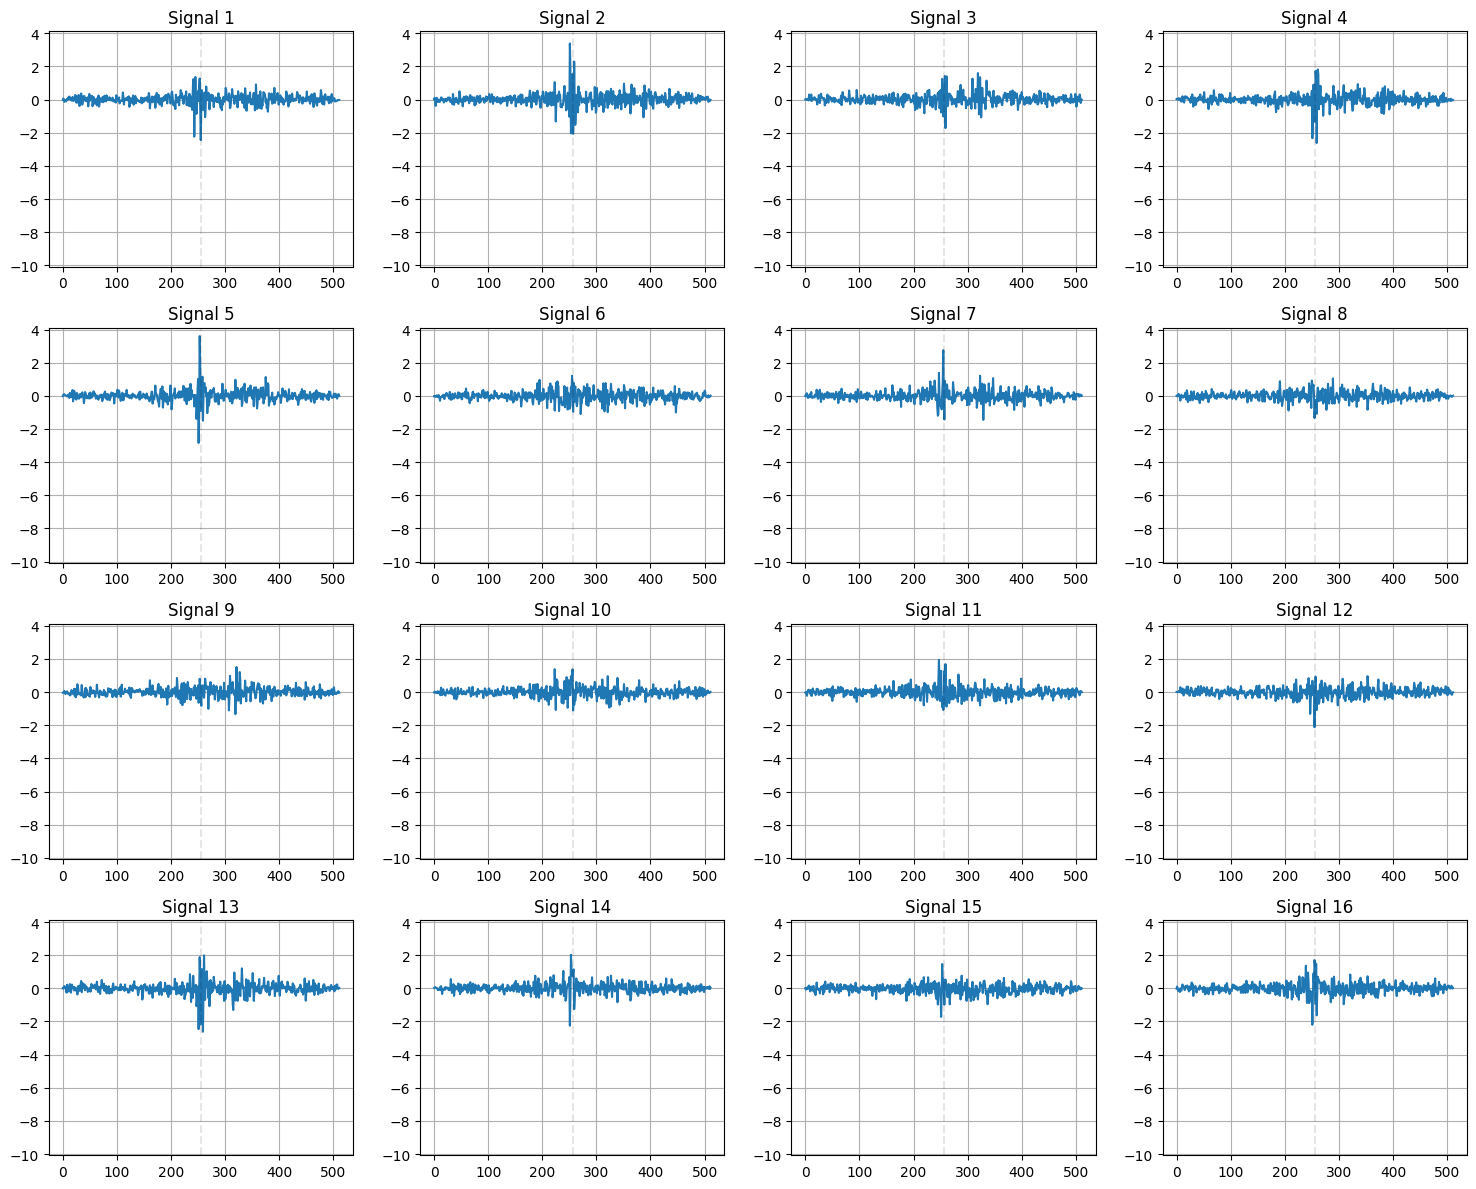

[3/32][0/111]	Loss_D: 1.0017	Loss_G: 2.3411	D(x): 0.0685	D(G(z)): 0.6411 / 0.6747
[3/32][50/111]	Loss_D: 1.0430	Loss_G: 3.3698	D(x): 0.1358	D(G(z)): 0.8518 / 0.8097
[3/32][100/111]	Loss_D: 0.7789	Loss_G: 2.4694	D(x): 0.1865	D(G(z)): 0.8047 / 0.7380


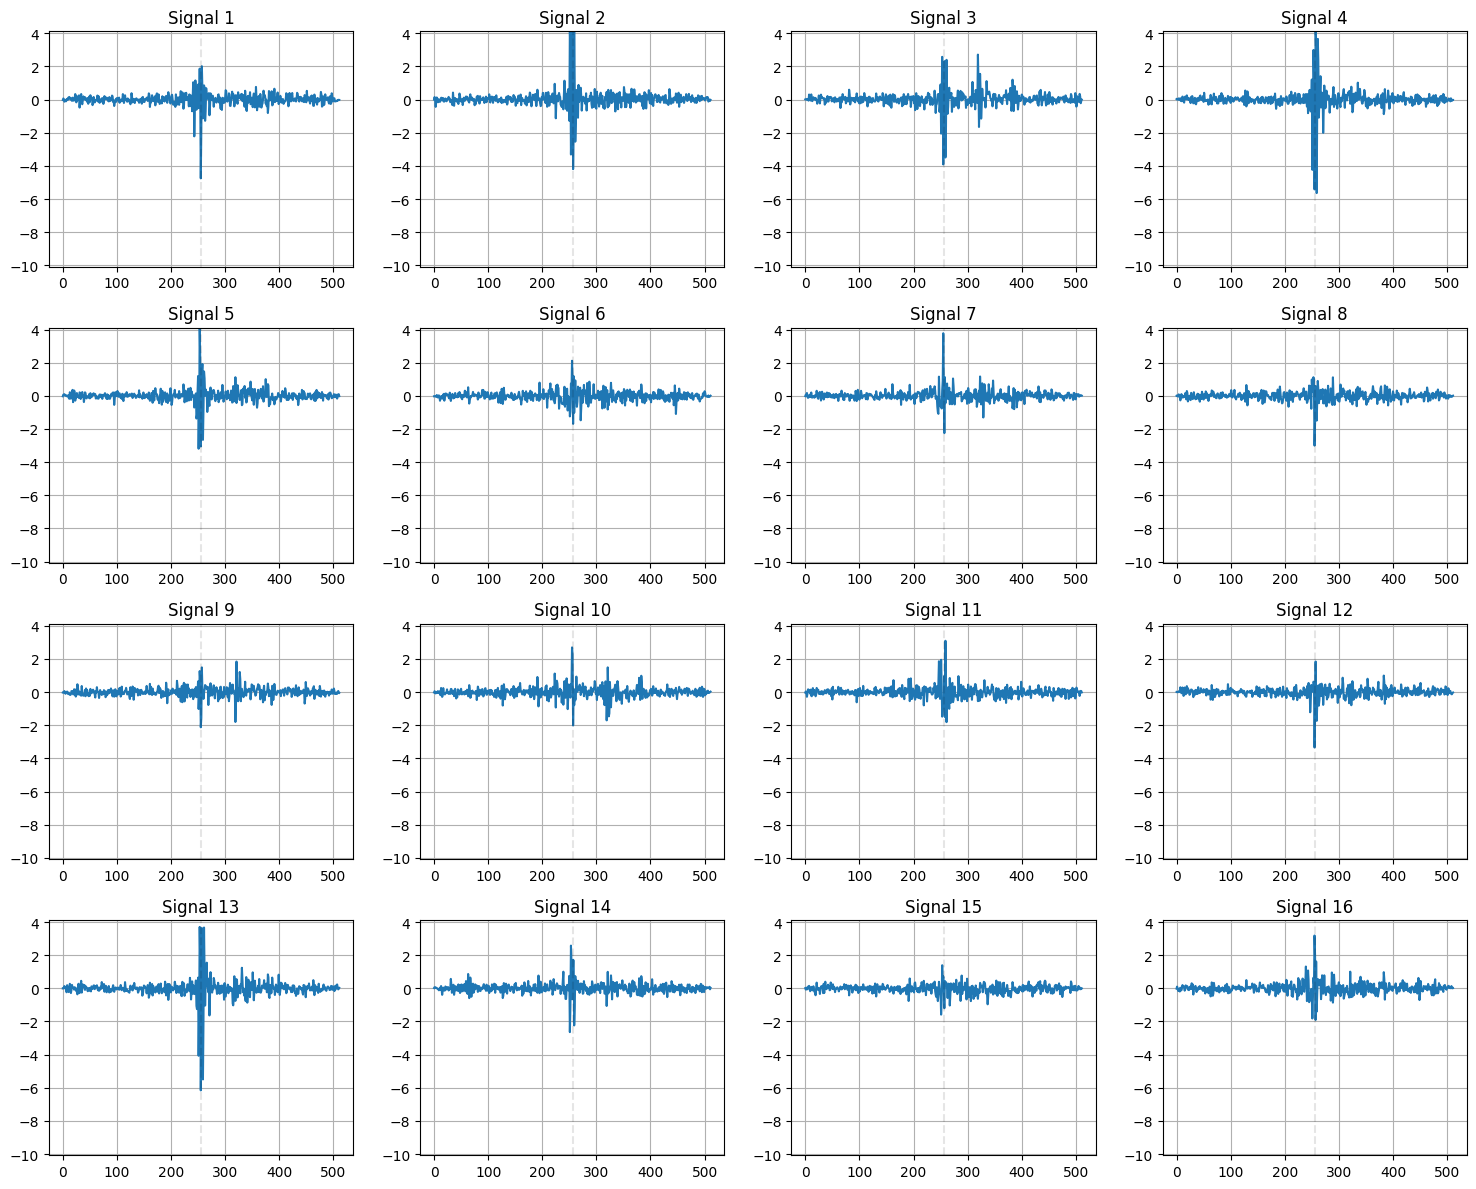

[4/32][0/111]	Loss_D: 0.8826	Loss_G: 2.7577	D(x): 0.2174	D(G(z)): 0.8263 / 0.7567
[4/32][50/111]	Loss_D: 1.0352	Loss_G: 1.8849	D(x): 0.2355	D(G(z)): 0.8258 / 0.6972
[4/32][100/111]	Loss_D: 0.9956	Loss_G: 2.9116	D(x): 0.1125	D(G(z)): 0.8140 / 0.8241


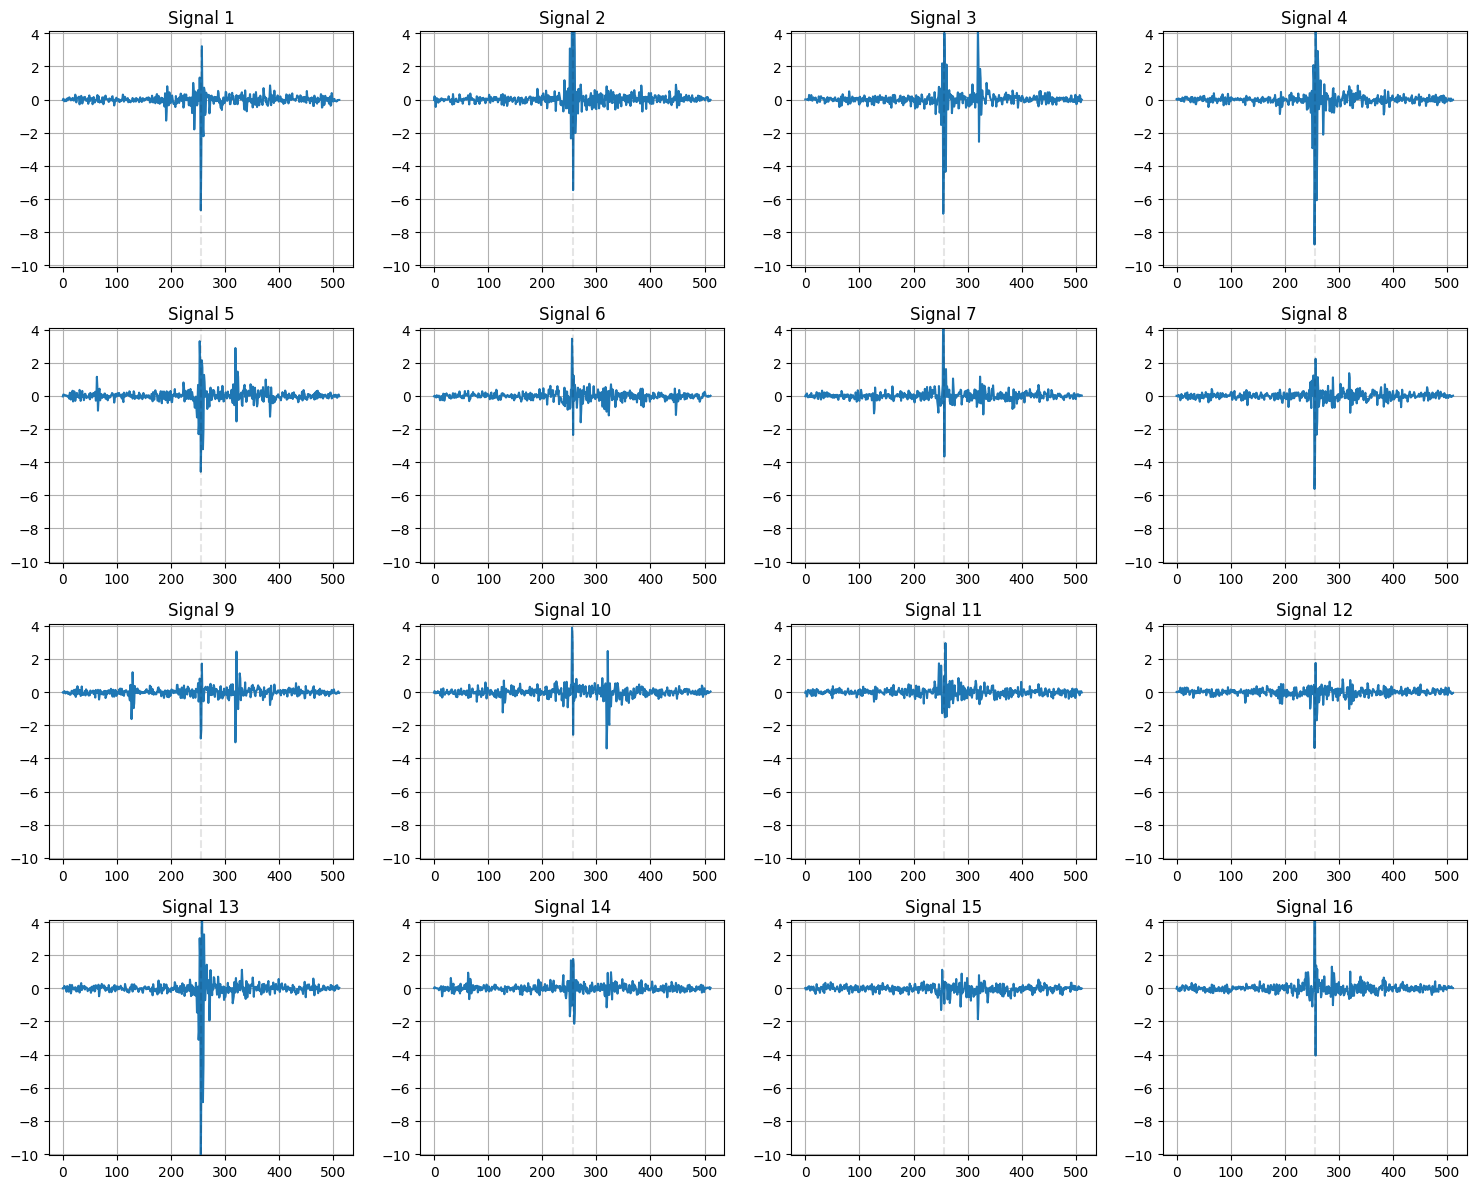

[5/32][0/111]	Loss_D: 0.8498	Loss_G: 1.5441	D(x): 0.1263	D(G(z)): 0.7027 / 0.6223
[5/32][50/111]	Loss_D: 0.7892	Loss_G: 3.3108	D(x): 0.1421	D(G(z)): 0.7668 / 0.8293
[5/32][100/111]	Loss_D: 0.7850	Loss_G: 3.0735	D(x): 0.1740	D(G(z)): 0.7860 / 0.7894


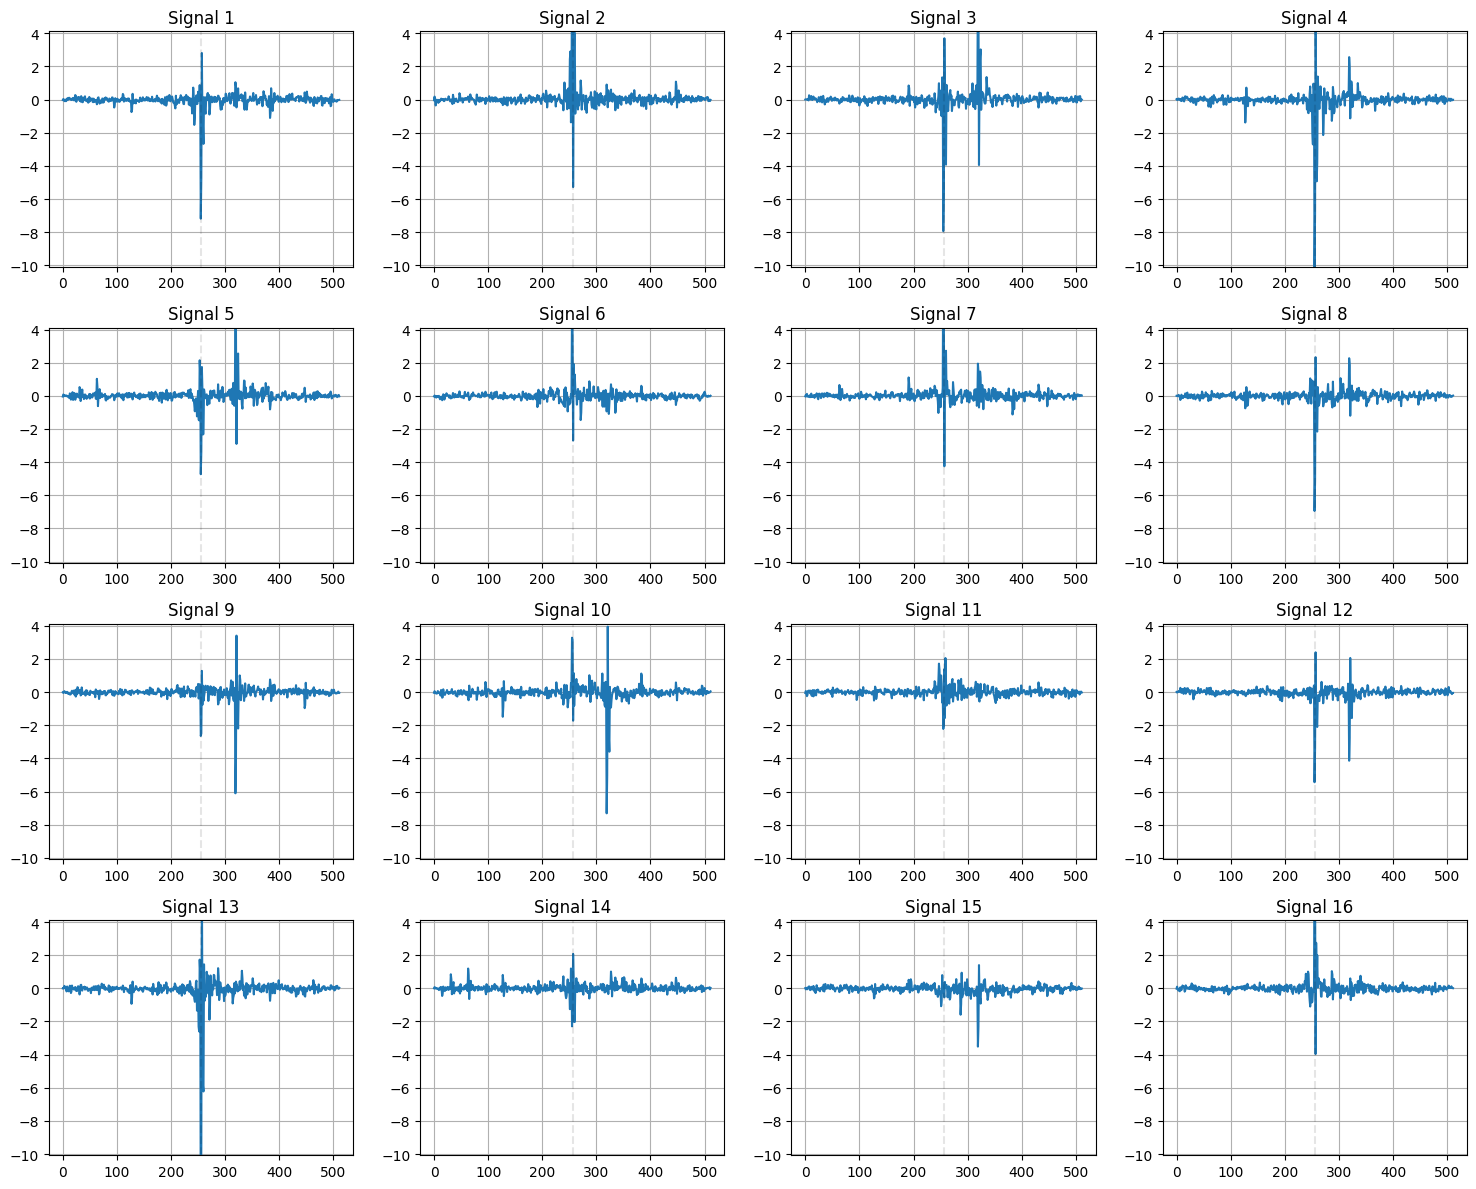

[6/32][0/111]	Loss_D: 0.8418	Loss_G: 1.5028	D(x): 0.0948	D(G(z)): 0.5357 / 0.6400
[6/32][50/111]	Loss_D: 0.5932	Loss_G: 3.0210	D(x): 0.1373	D(G(z)): 0.8342 / 0.8051
[6/32][100/111]	Loss_D: 0.8979	Loss_G: 3.1985	D(x): 0.1671	D(G(z)): 0.8527 / 0.8172


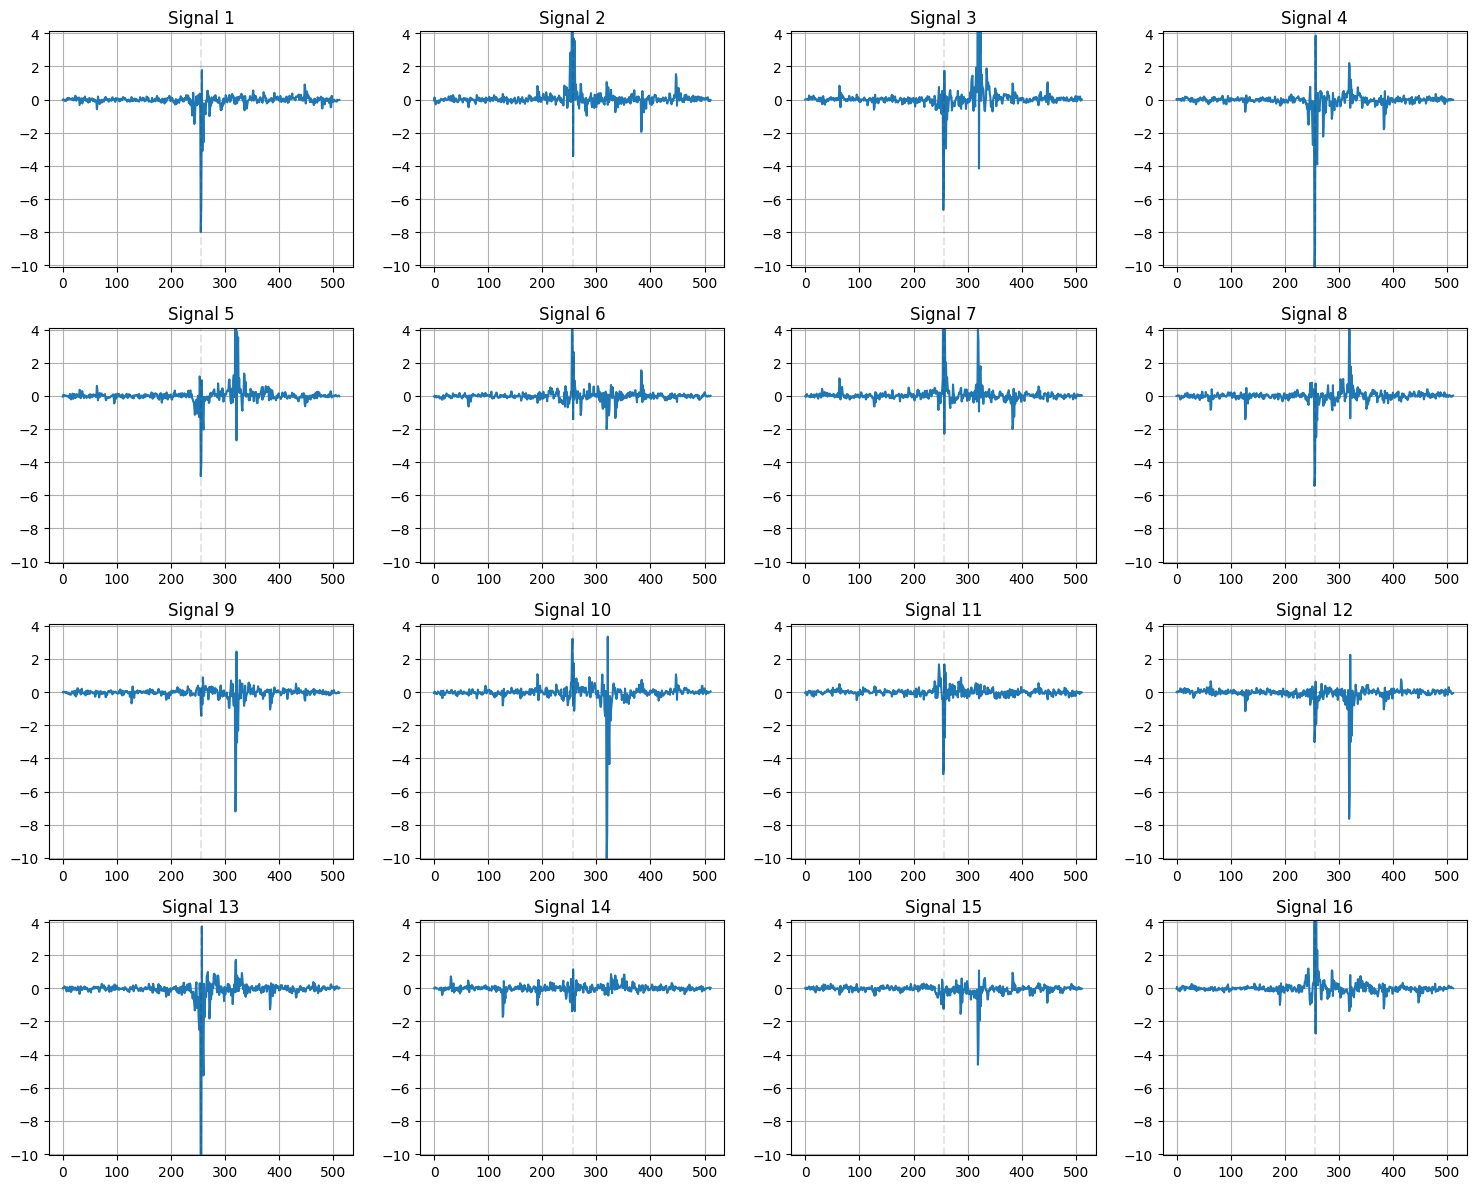

[7/32][0/111]	Loss_D: 0.8411	Loss_G: 3.0641	D(x): 0.0882	D(G(z)): 0.7794 / 0.7921
[7/32][50/111]	Loss_D: 0.6675	Loss_G: 3.3668	D(x): 0.1476	D(G(z)): 0.8217 / 0.8335
[7/32][100/111]	Loss_D: 0.6097	Loss_G: 2.5867	D(x): 0.1123	D(G(z)): 0.8095 / 0.7563


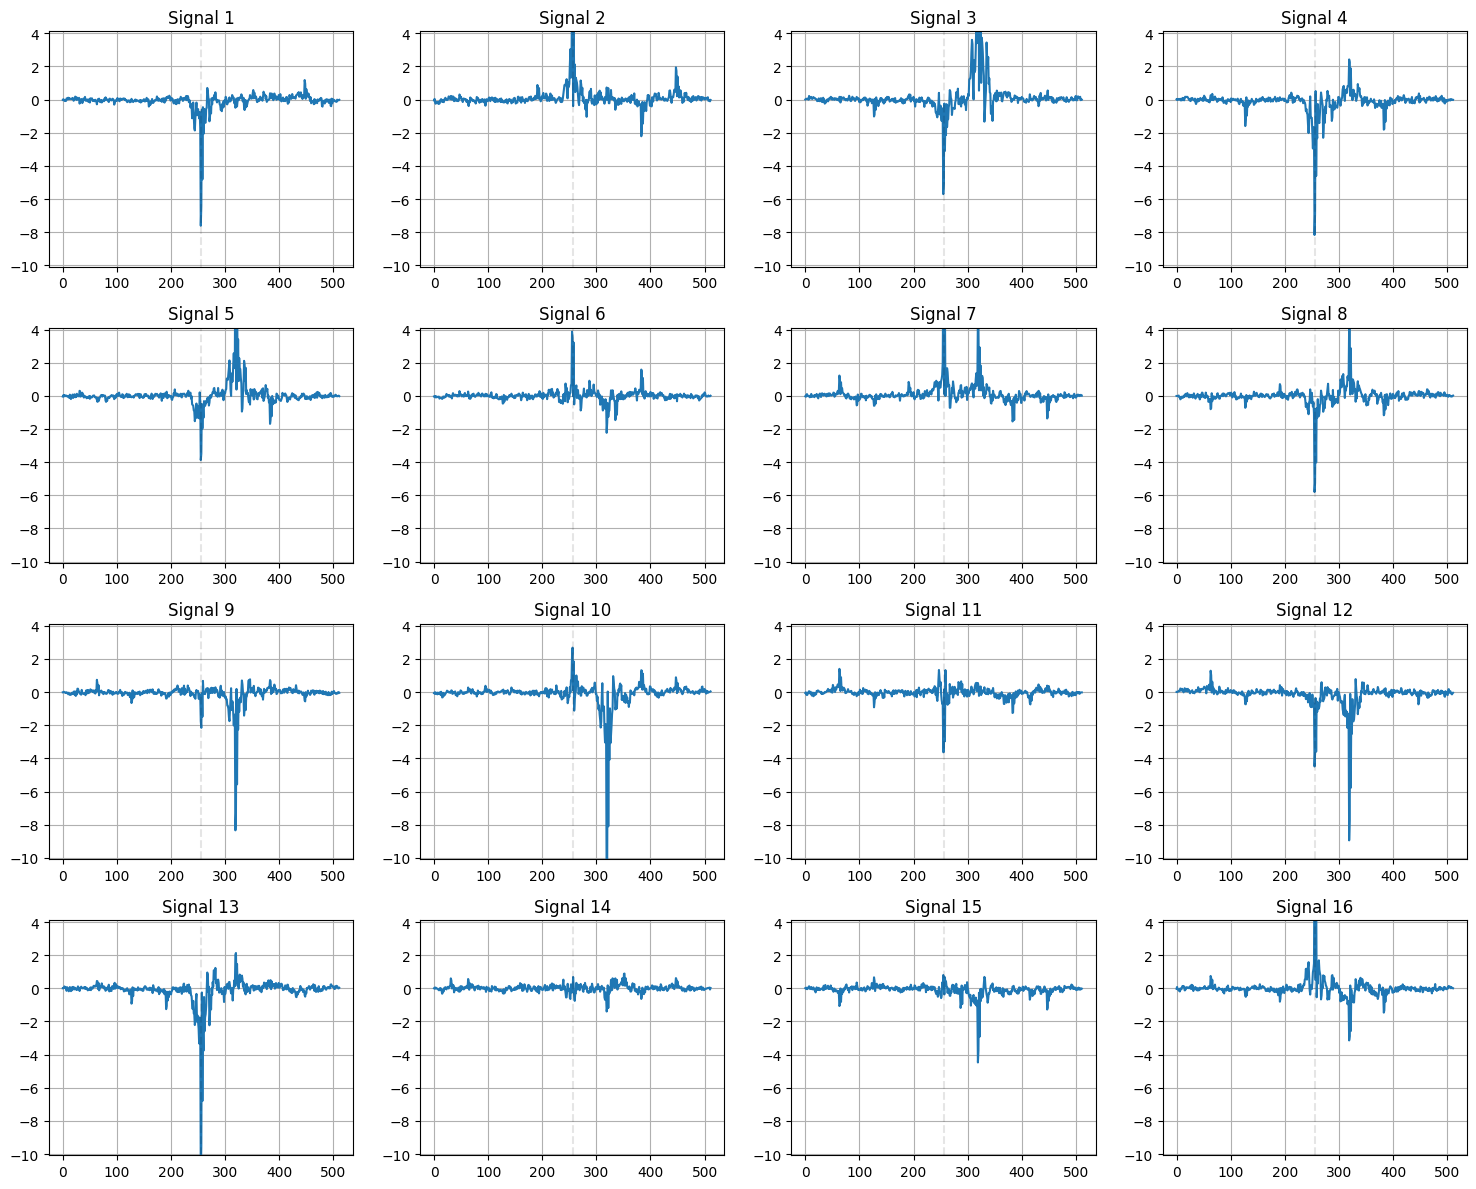

[8/32][0/111]	Loss_D: 0.8833	Loss_G: 4.5130	D(x): 0.1455	D(G(z)): 0.8618 / 0.9113
[8/32][50/111]	Loss_D: 0.6392	Loss_G: 3.1132	D(x): 0.1117	D(G(z)): 0.7124 / 0.8478
[8/32][100/111]	Loss_D: 1.2871	Loss_G: 3.3647	D(x): 0.1802	D(G(z)): 0.6647 / 0.8008


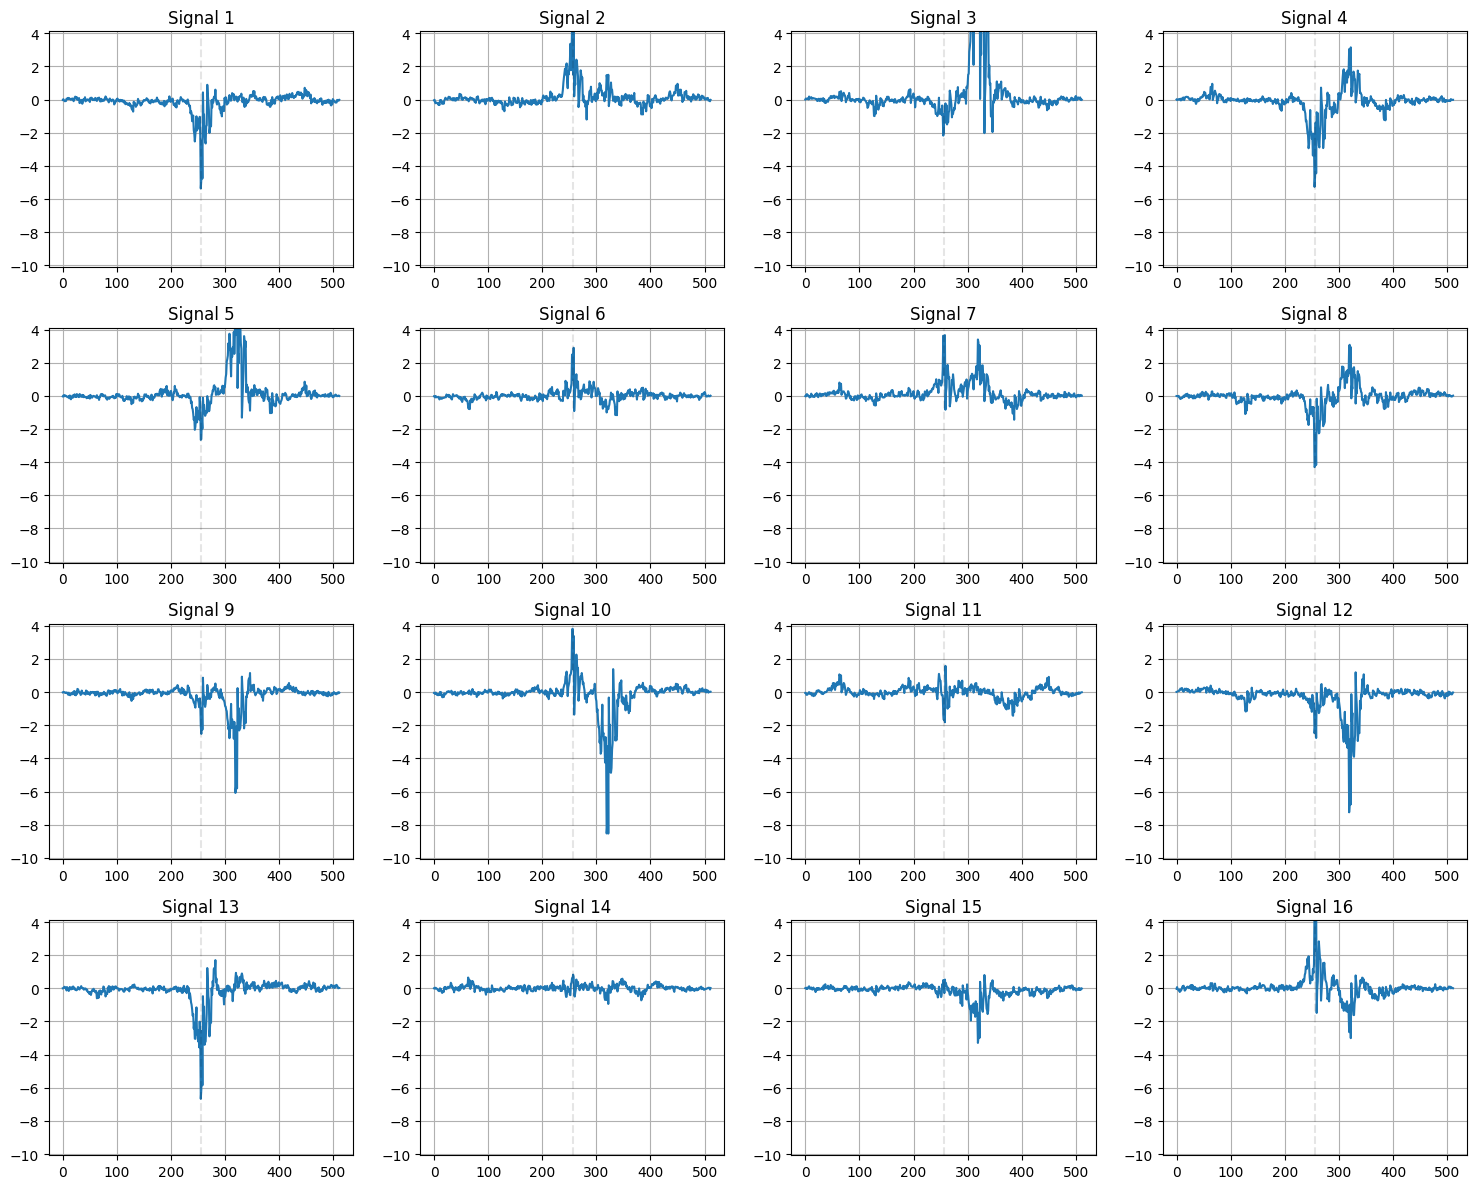

[9/32][0/111]	Loss_D: 0.8513	Loss_G: 2.7530	D(x): 0.1221	D(G(z)): 0.8129 / 0.8037
[9/32][50/111]	Loss_D: 0.8438	Loss_G: 2.7252	D(x): 0.1485	D(G(z)): 0.8412 / 0.8149
[9/32][100/111]	Loss_D: 0.6730	Loss_G: 1.8310	D(x): 0.0846	D(G(z)): 0.8188 / 0.6919


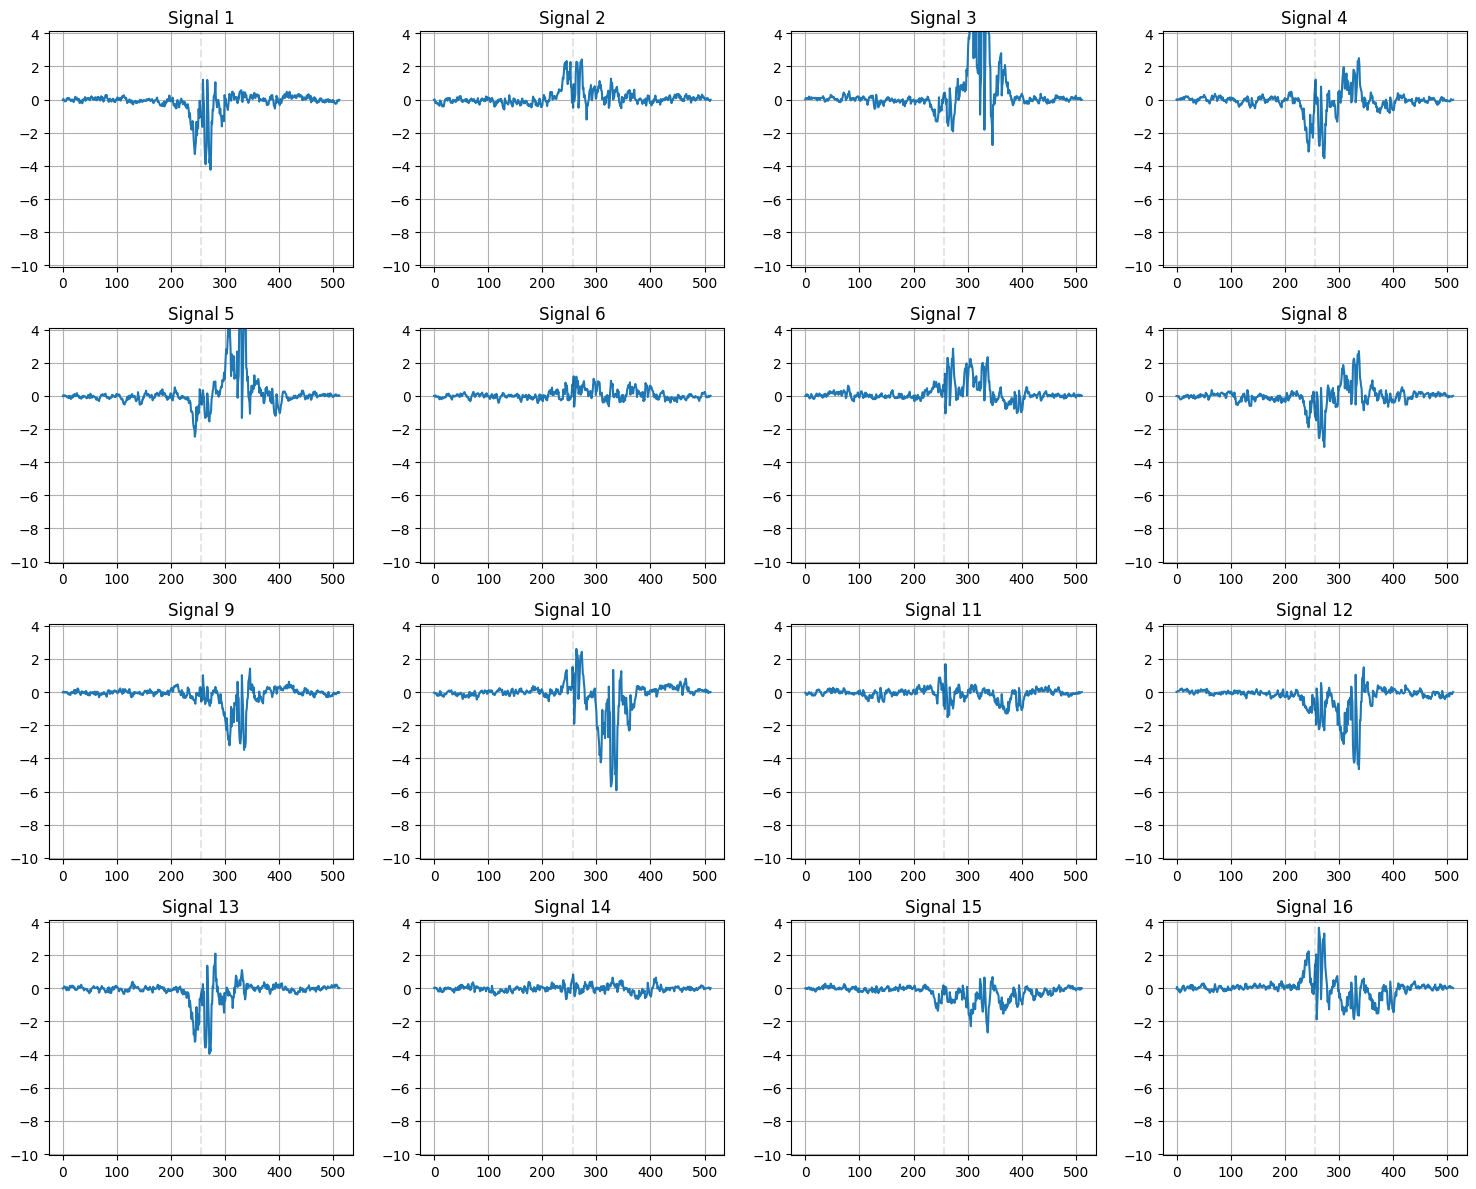

[10/32][0/111]	Loss_D: 1.0261	Loss_G: 2.5045	D(x): 0.0933	D(G(z)): 0.7799 / 0.7168
[10/32][50/111]	Loss_D: 0.6584	Loss_G: 2.5058	D(x): 0.1704	D(G(z)): 0.7792 / 0.7704
[10/32][100/111]	Loss_D: 0.9064	Loss_G: 3.1900	D(x): 0.1559	D(G(z)): 0.7310 / 0.7503


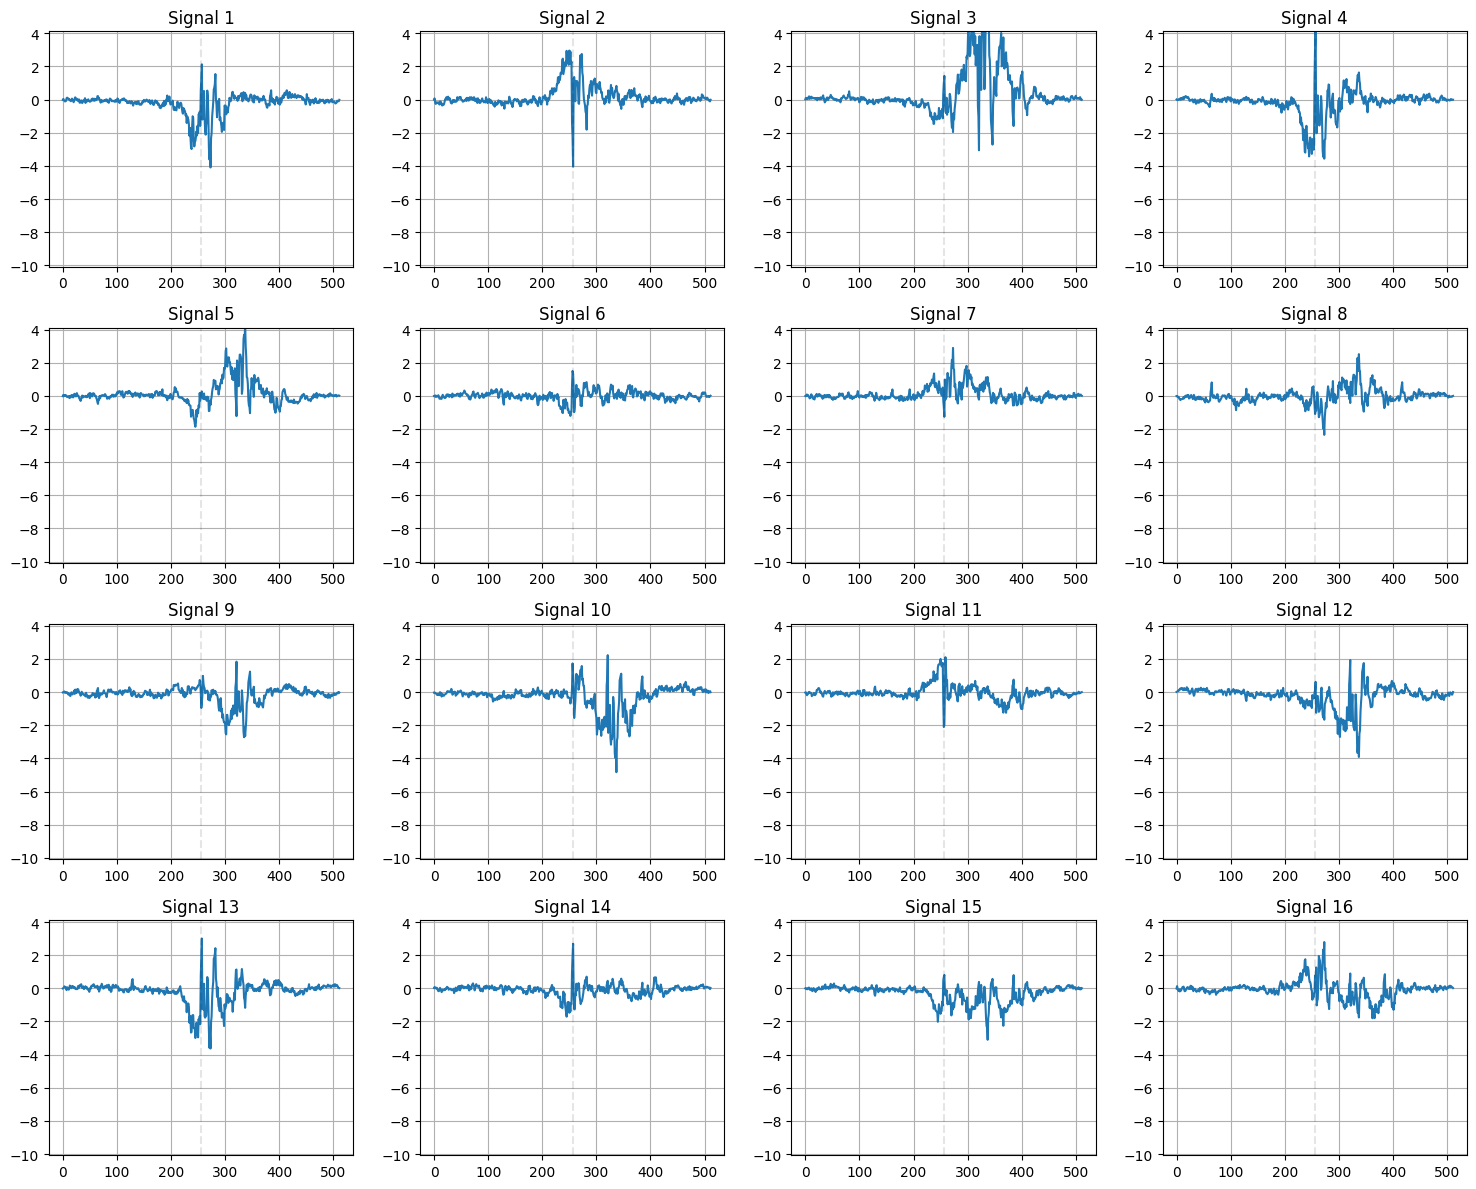

[11/32][0/111]	Loss_D: 1.3358	Loss_G: 2.0061	D(x): 0.1721	D(G(z)): 0.4881 / 0.6255
[11/32][50/111]	Loss_D: 1.5316	Loss_G: 1.9608	D(x): 0.1705	D(G(z)): 0.4750 / 0.7166
[11/32][100/111]	Loss_D: 0.9060	Loss_G: 2.4831	D(x): 0.0838	D(G(z)): 0.6231 / 0.7691


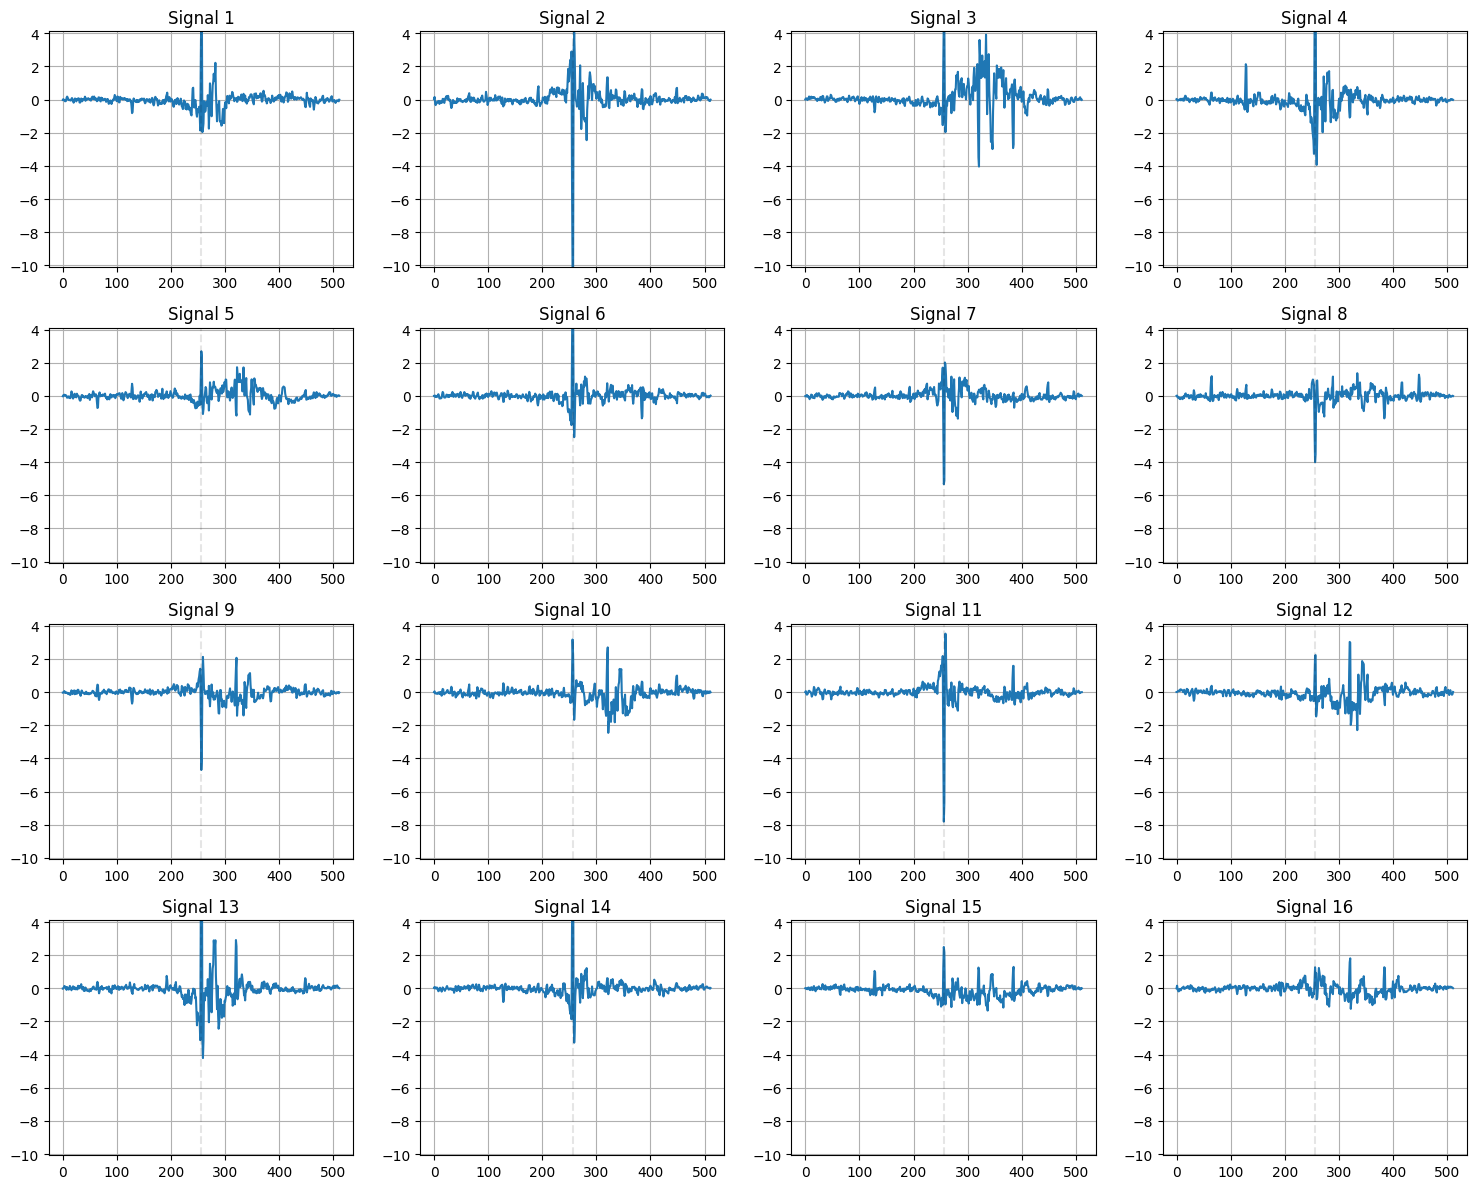

[12/32][0/111]	Loss_D: 0.8323	Loss_G: 1.9504	D(x): 0.1383	D(G(z)): 0.6581 / 0.6559
[12/32][50/111]	Loss_D: 0.9081	Loss_G: 1.3433	D(x): 0.1784	D(G(z)): 0.7207 / 0.6313
[12/32][100/111]	Loss_D: 0.6954	Loss_G: 2.1901	D(x): 0.1485	D(G(z)): 0.7528 / 0.7024


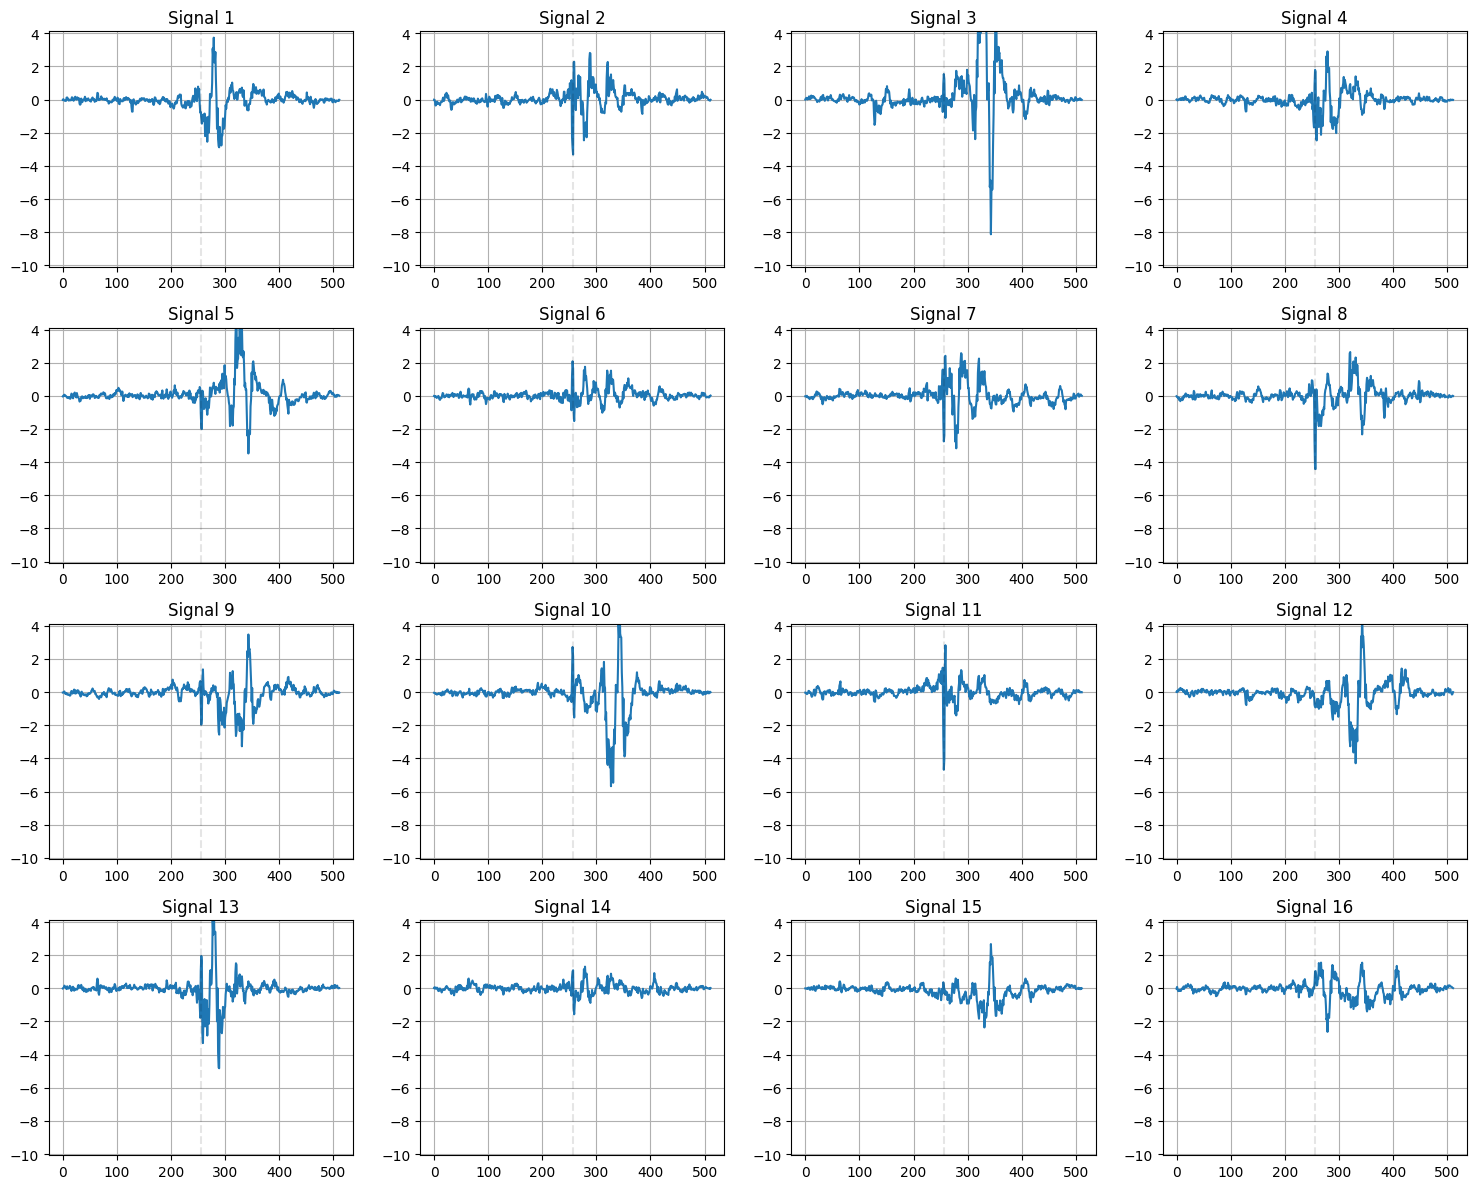

[13/32][0/111]	Loss_D: 0.7829	Loss_G: 2.5862	D(x): 0.0899	D(G(z)): 0.7708 / 0.7650
[13/32][50/111]	Loss_D: 0.6261	Loss_G: 3.4071	D(x): 0.1117	D(G(z)): 0.7695 / 0.8355
[13/32][100/111]	Loss_D: 1.5110	Loss_G: 3.3805	D(x): 0.2238	D(G(z)): 0.8921 / 0.8140


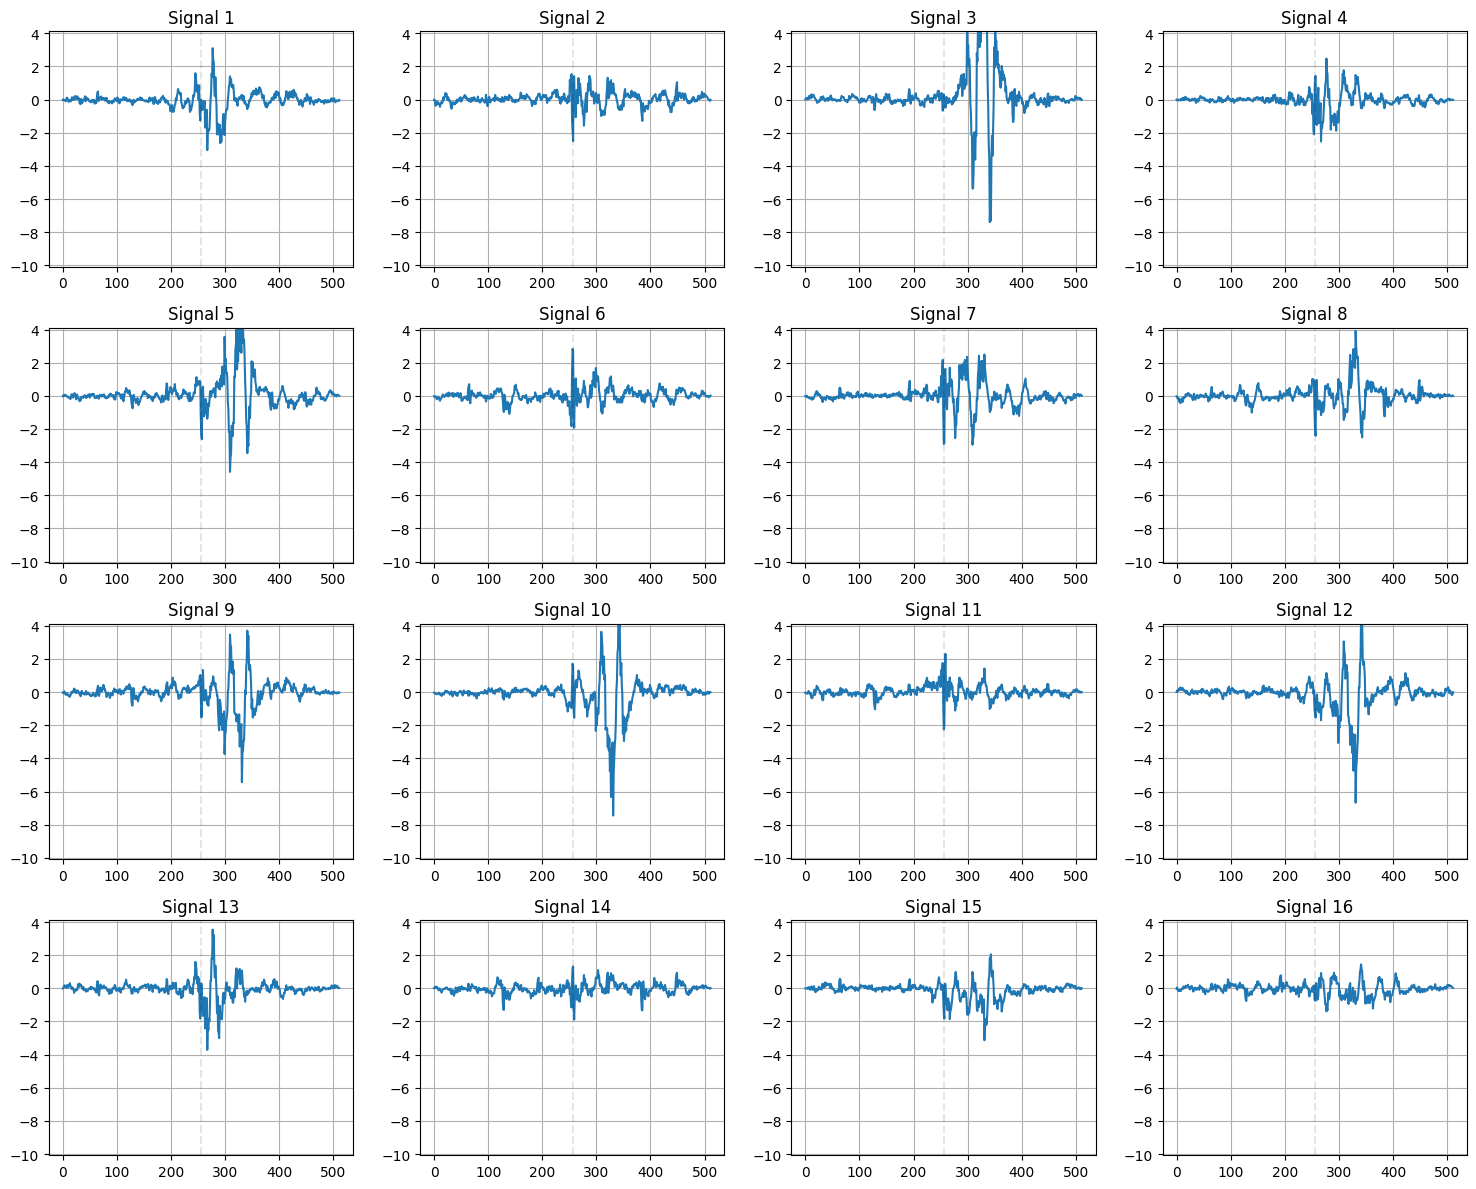

[14/32][0/111]	Loss_D: 1.2539	Loss_G: 2.0568	D(x): 0.1286	D(G(z)): 0.5132 / 0.6670
[14/32][50/111]	Loss_D: 0.9530	Loss_G: 3.2020	D(x): 0.2241	D(G(z)): 0.7528 / 0.7883
[14/32][100/111]	Loss_D: 1.0903	Loss_G: 1.8127	D(x): 0.1267	D(G(z)): 0.7144 / 0.6875


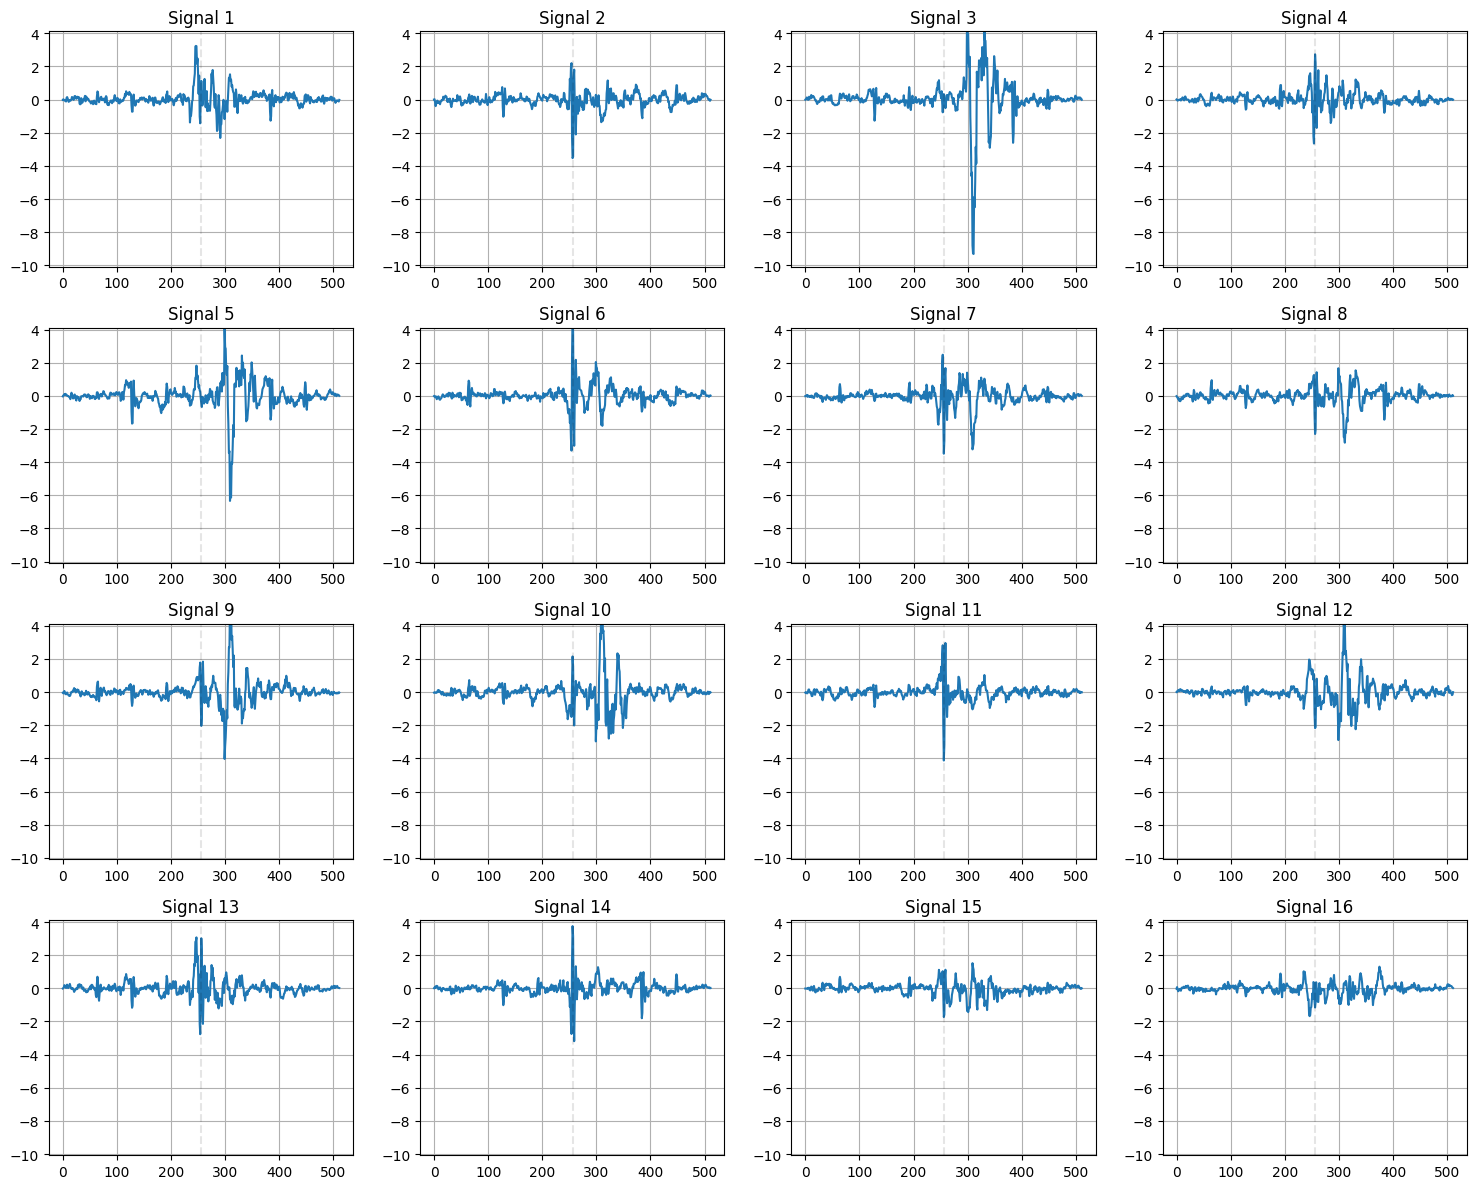

[15/32][0/111]	Loss_D: 0.9988	Loss_G: 3.5527	D(x): 0.2076	D(G(z)): 0.7618 / 0.7884
[15/32][50/111]	Loss_D: 0.9559	Loss_G: 1.9075	D(x): 0.2973	D(G(z)): 0.8109 / 0.6908
[15/32][100/111]	Loss_D: 0.8505	Loss_G: 2.6929	D(x): 0.2061	D(G(z)): 0.7526 / 0.8199


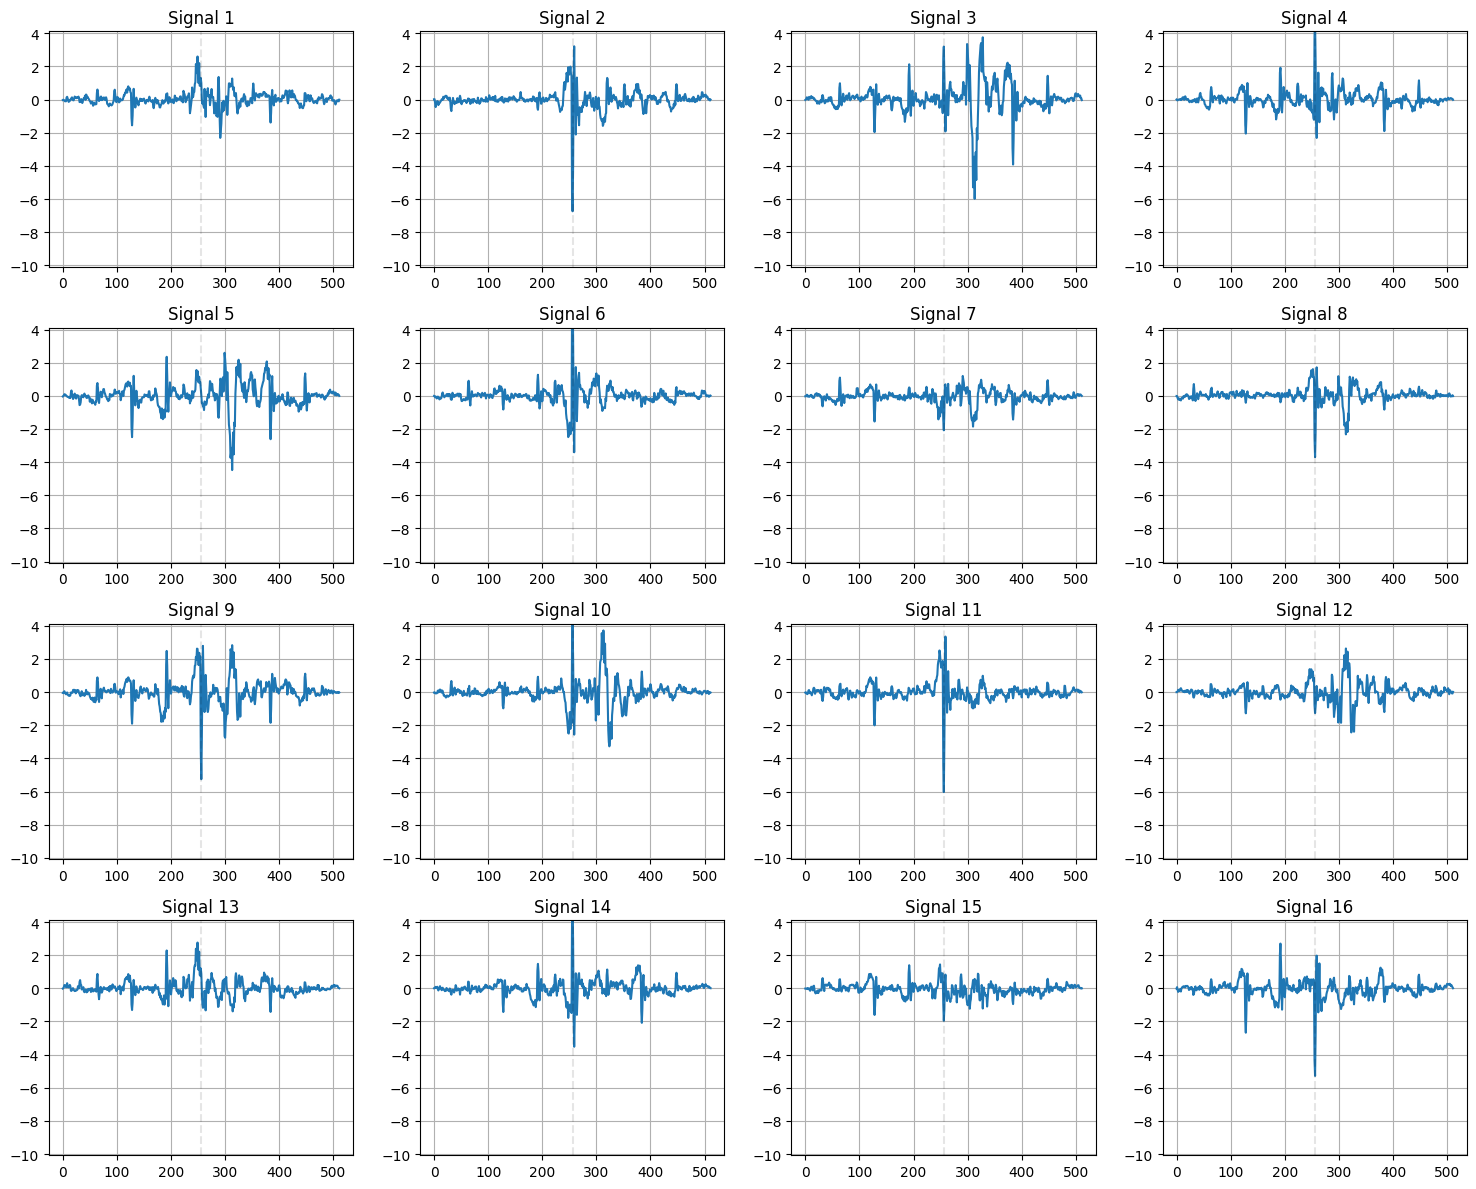

[16/32][0/111]	Loss_D: 0.5360	Loss_G: 1.7800	D(x): 0.1125	D(G(z)): 0.7135 / 0.6897
[16/32][50/111]	Loss_D: 1.0713	Loss_G: 2.4722	D(x): 0.2528	D(G(z)): 0.7928 / 0.7644
[16/32][100/111]	Loss_D: 1.1398	Loss_G: 3.4484	D(x): 0.1281	D(G(z)): 0.8596 / 0.7949


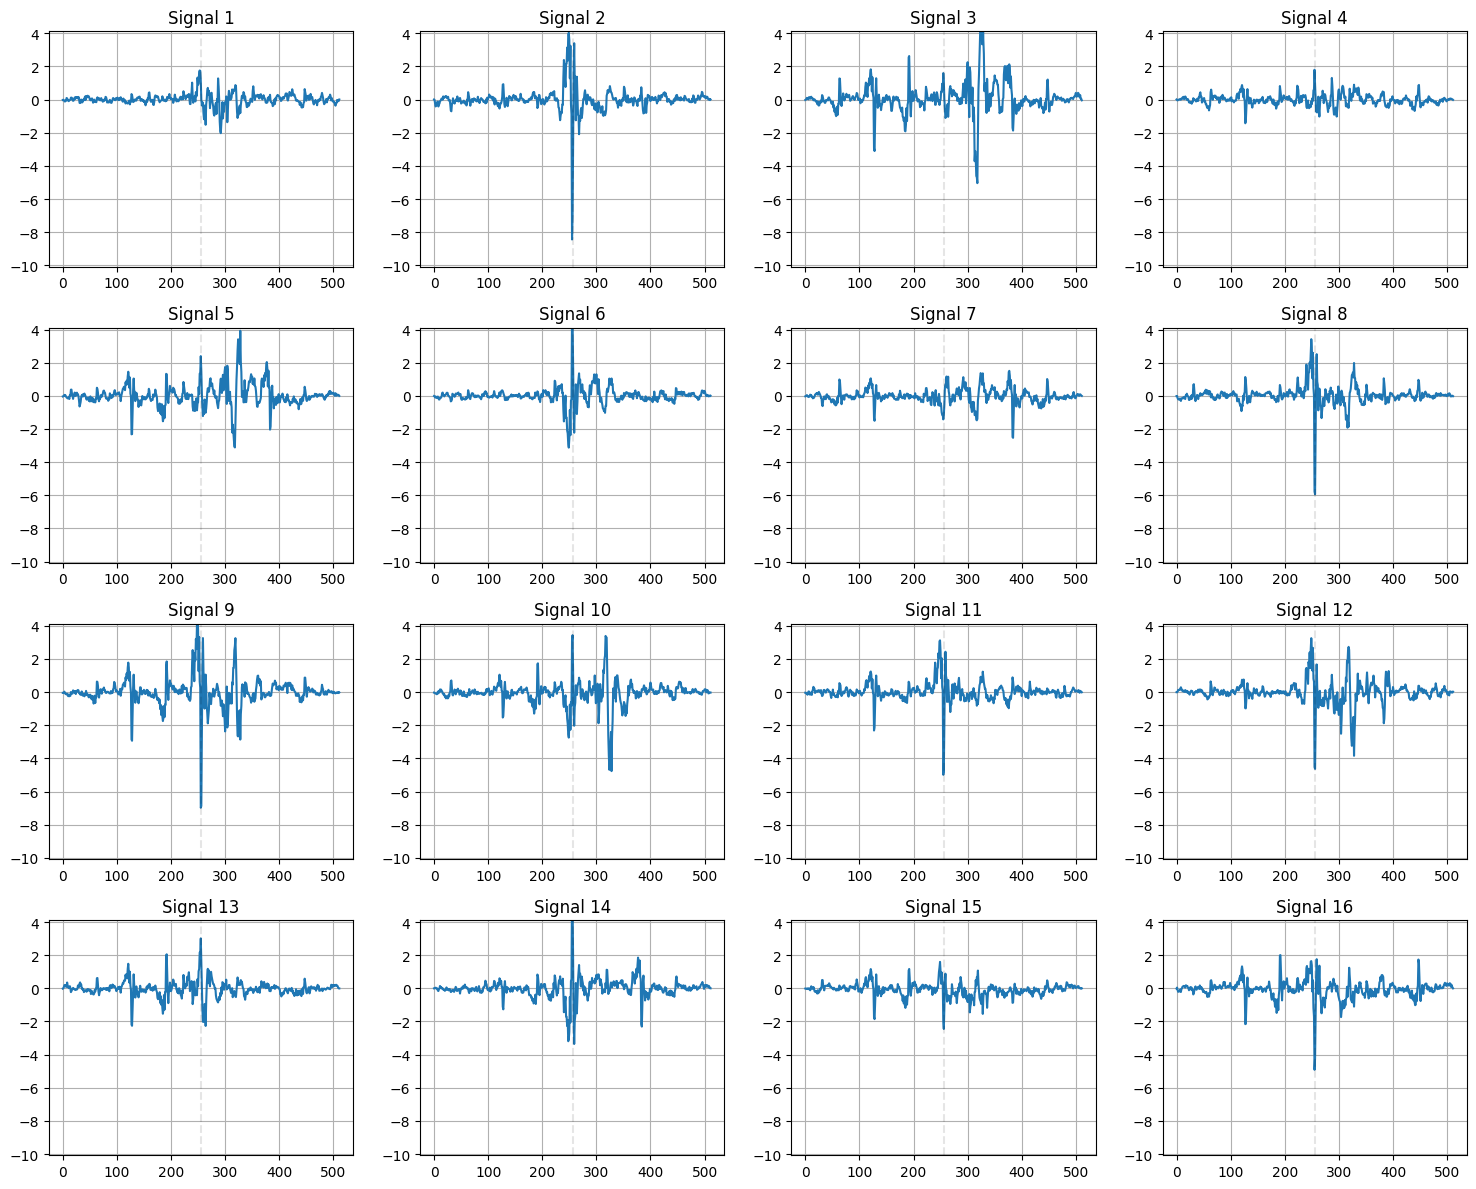

[17/32][0/111]	Loss_D: 1.2178	Loss_G: 2.8018	D(x): 0.1586	D(G(z)): 0.7389 / 0.7947
[17/32][50/111]	Loss_D: 0.6484	Loss_G: 4.0299	D(x): 0.1208	D(G(z)): 0.7961 / 0.9016
[17/32][100/111]	Loss_D: 0.6434	Loss_G: 2.4007	D(x): 0.1684	D(G(z)): 0.6892 / 0.7677


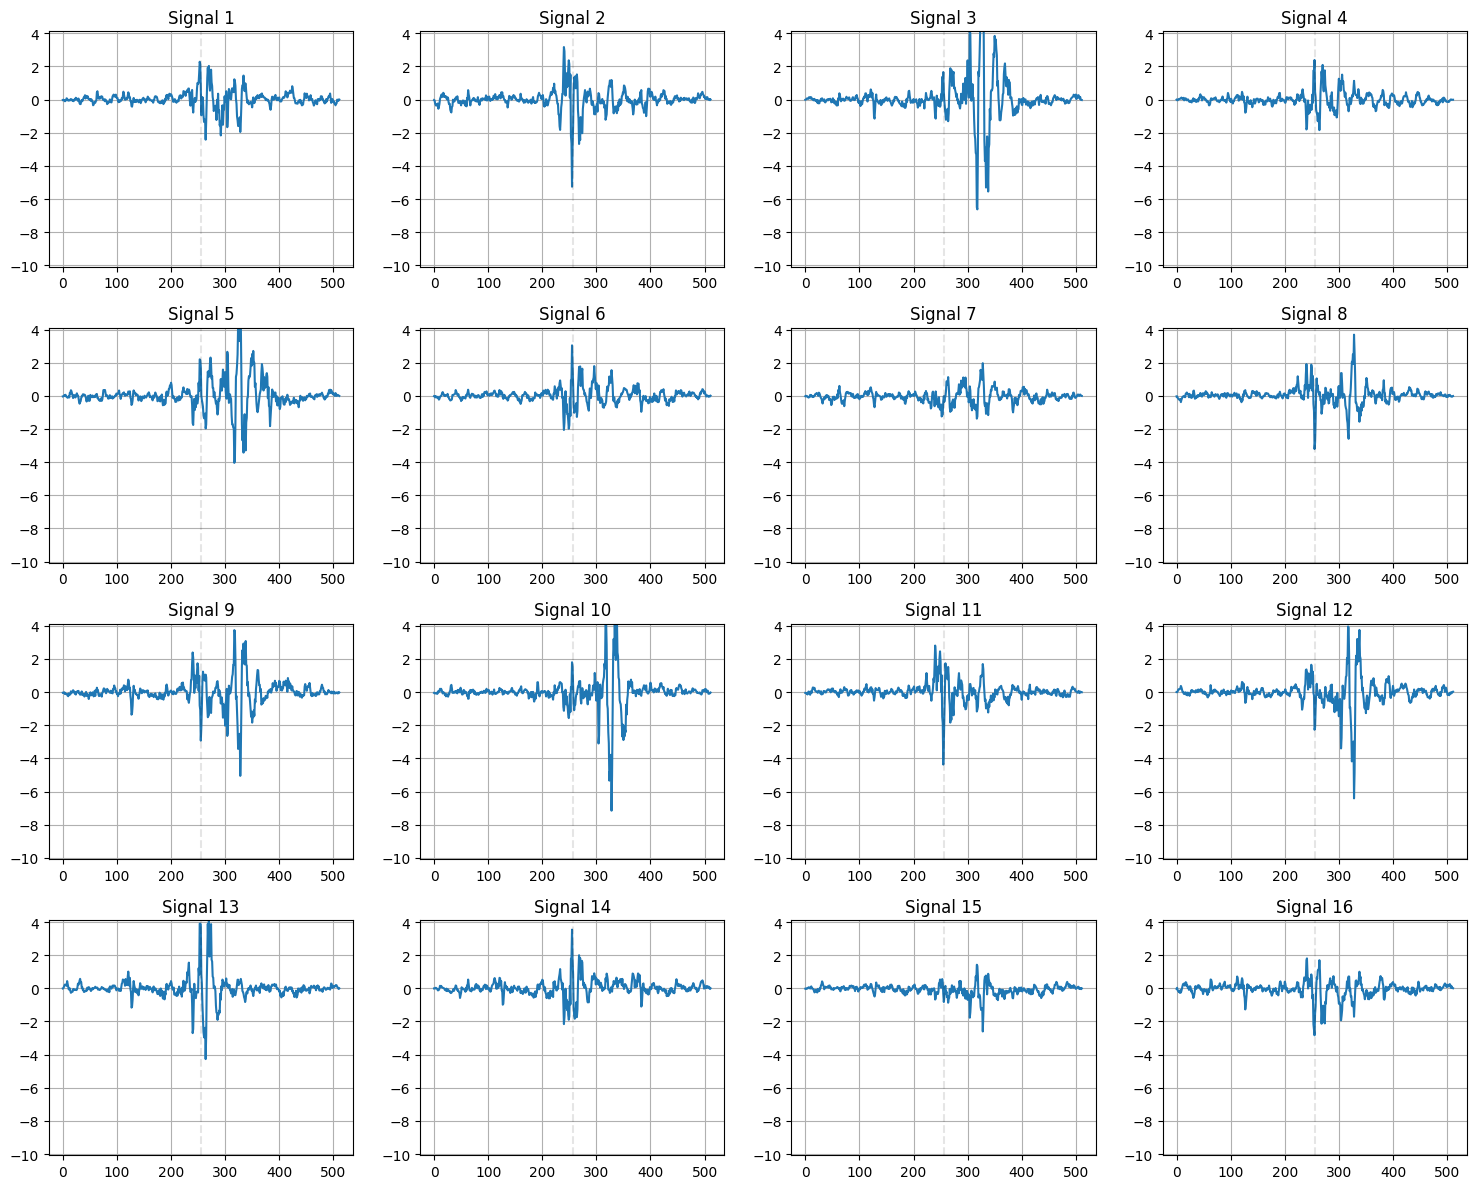

[18/32][0/111]	Loss_D: 1.2664	Loss_G: 1.5521	D(x): 0.1821	D(G(z)): 0.6686 / 0.6438
[18/32][50/111]	Loss_D: 1.0529	Loss_G: 2.1048	D(x): 0.1770	D(G(z)): 0.8241 / 0.7593
[18/32][100/111]	Loss_D: 0.6830	Loss_G: 3.1150	D(x): 0.1386	D(G(z)): 0.8060 / 0.8261


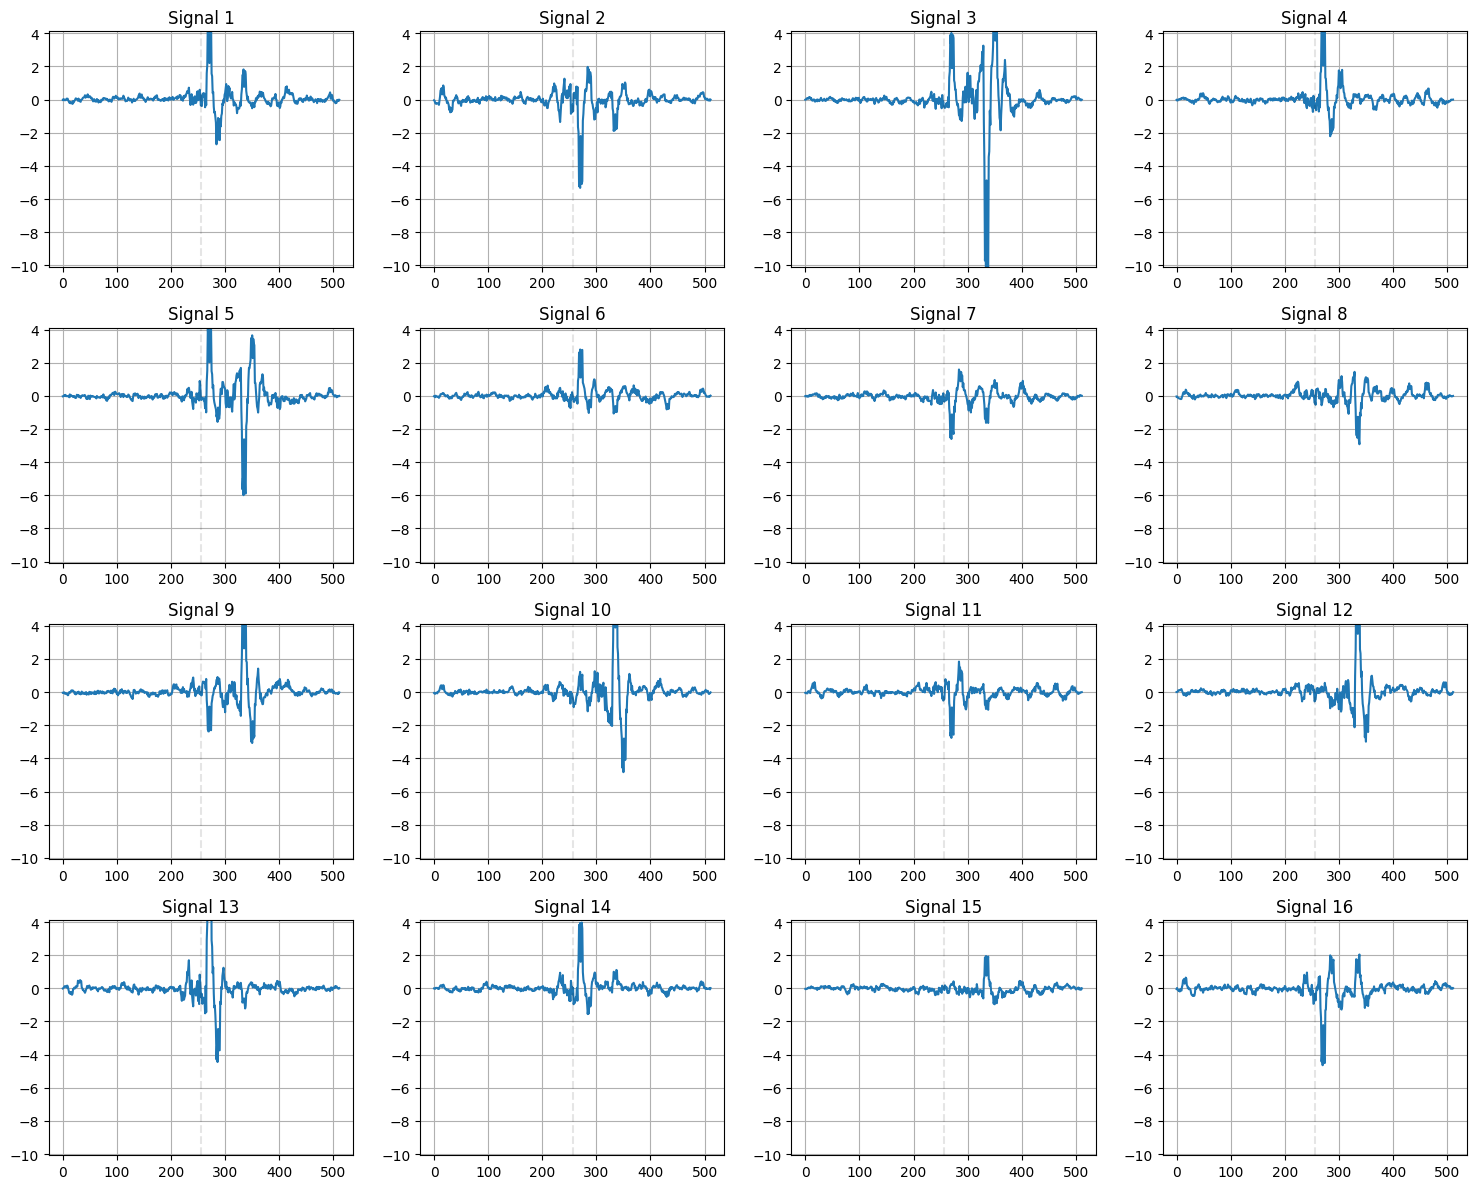

[19/32][0/111]	Loss_D: 1.1296	Loss_G: 1.5069	D(x): 0.1423	D(G(z)): 0.3933 / 0.6440
[19/32][50/111]	Loss_D: 1.0213	Loss_G: 2.4675	D(x): 0.1501	D(G(z)): 0.7386 / 0.7977
[19/32][100/111]	Loss_D: 1.0310	Loss_G: 2.4571	D(x): 0.1580	D(G(z)): 0.7364 / 0.7489


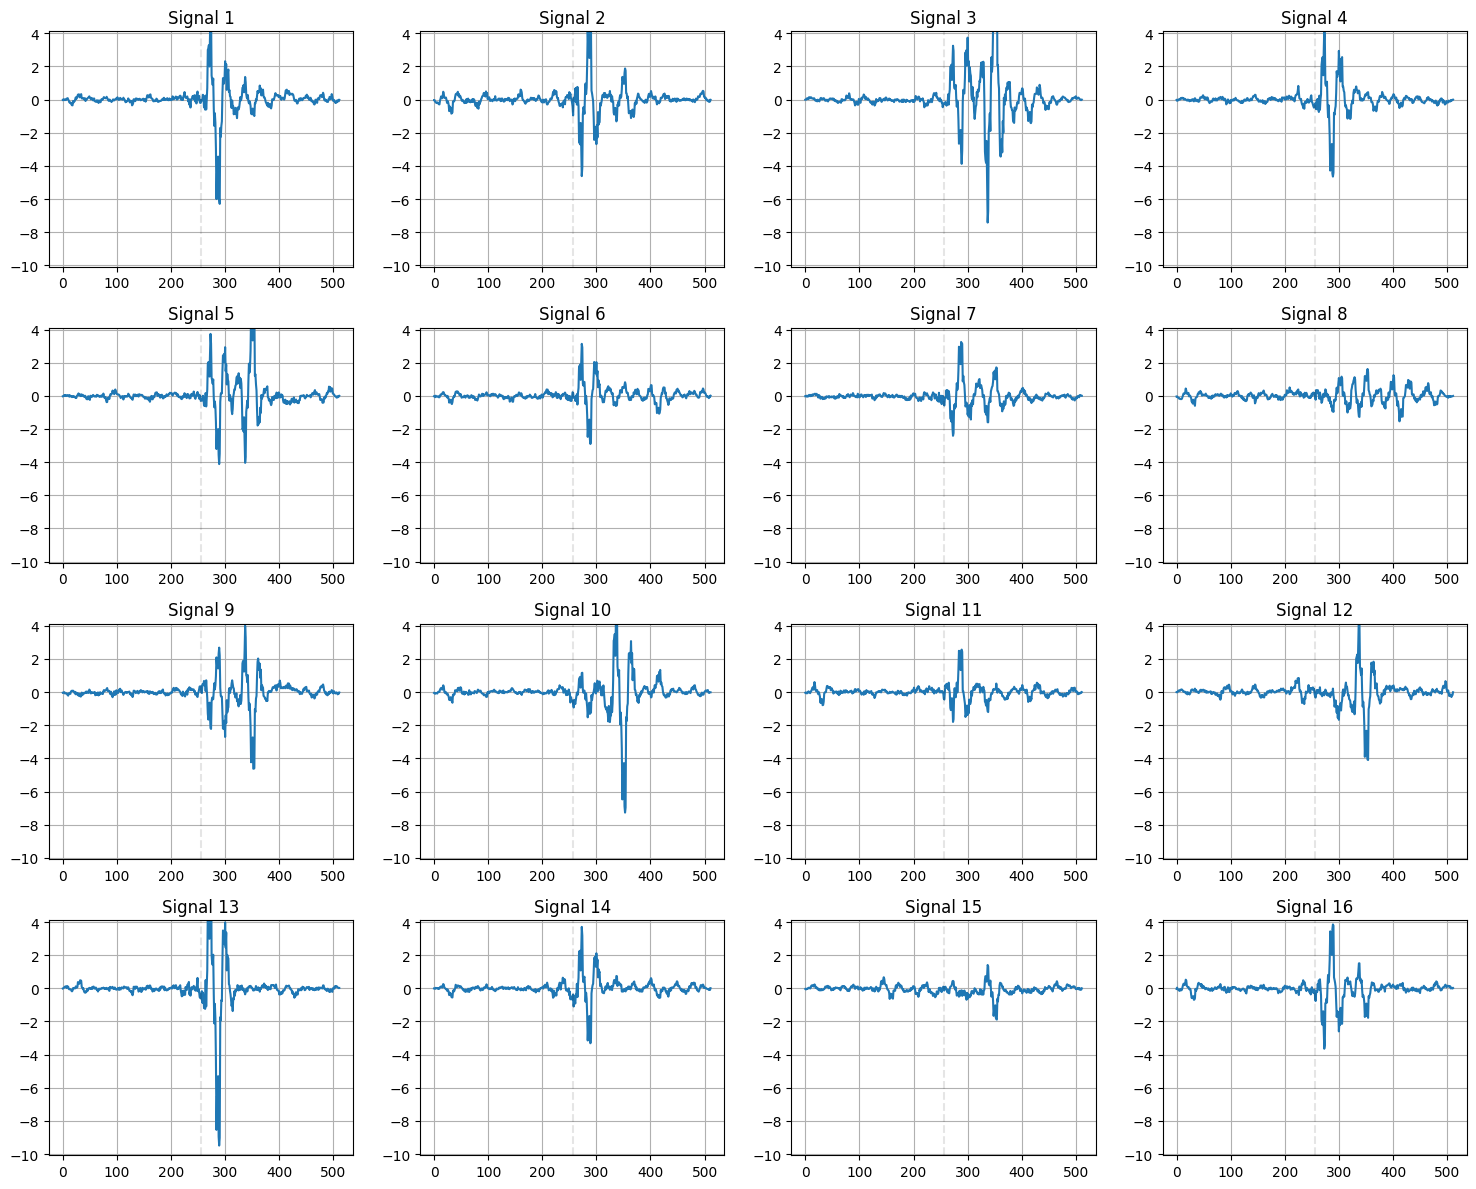

[20/32][0/111]	Loss_D: 0.8801	Loss_G: 1.4187	D(x): 0.1584	D(G(z)): 0.6348 / 0.6345
[20/32][50/111]	Loss_D: 0.6498	Loss_G: 2.4094	D(x): 0.0715	D(G(z)): 0.7440 / 0.7458
[20/32][100/111]	Loss_D: 1.0084	Loss_G: 2.5600	D(x): 0.2037	D(G(z)): 0.7531 / 0.7837


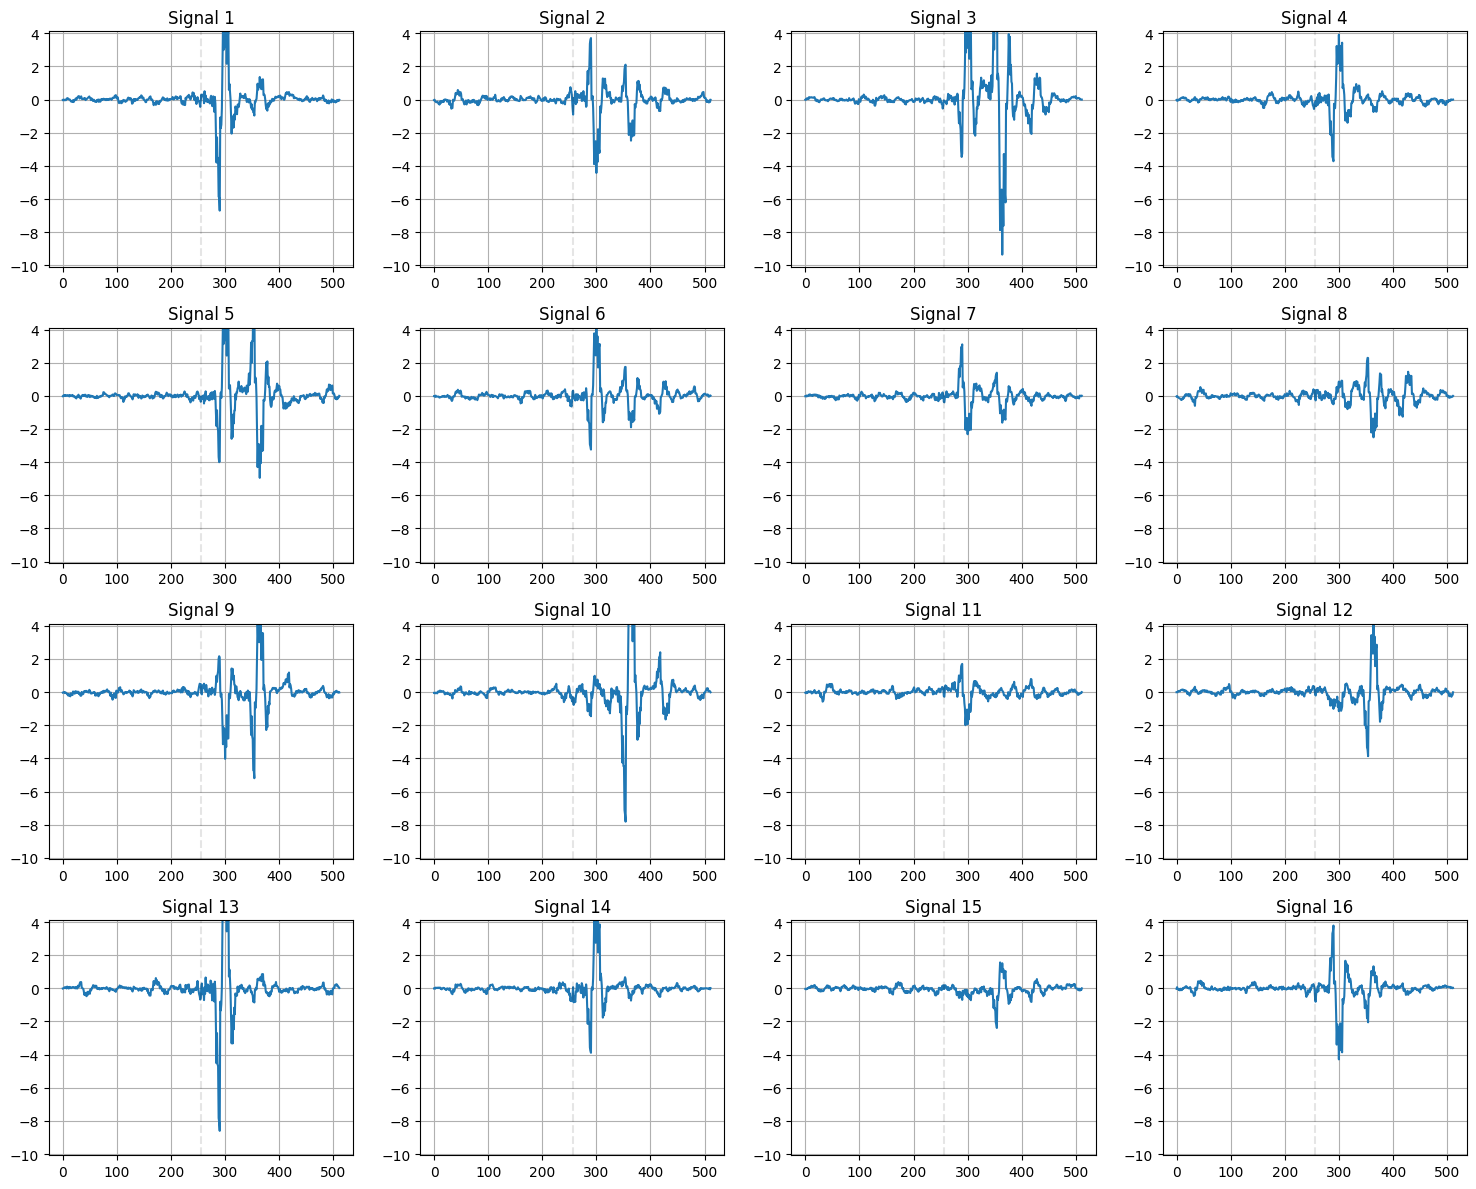

[21/32][0/111]	Loss_D: 0.6323	Loss_G: 2.5317	D(x): 0.0828	D(G(z)): 0.8222 / 0.7400
[21/32][50/111]	Loss_D: 0.7033	Loss_G: 2.3317	D(x): 0.1568	D(G(z)): 0.7237 / 0.7579
[21/32][100/111]	Loss_D: 1.2052	Loss_G: 3.6036	D(x): 0.0971	D(G(z)): 0.4342 / 0.8020


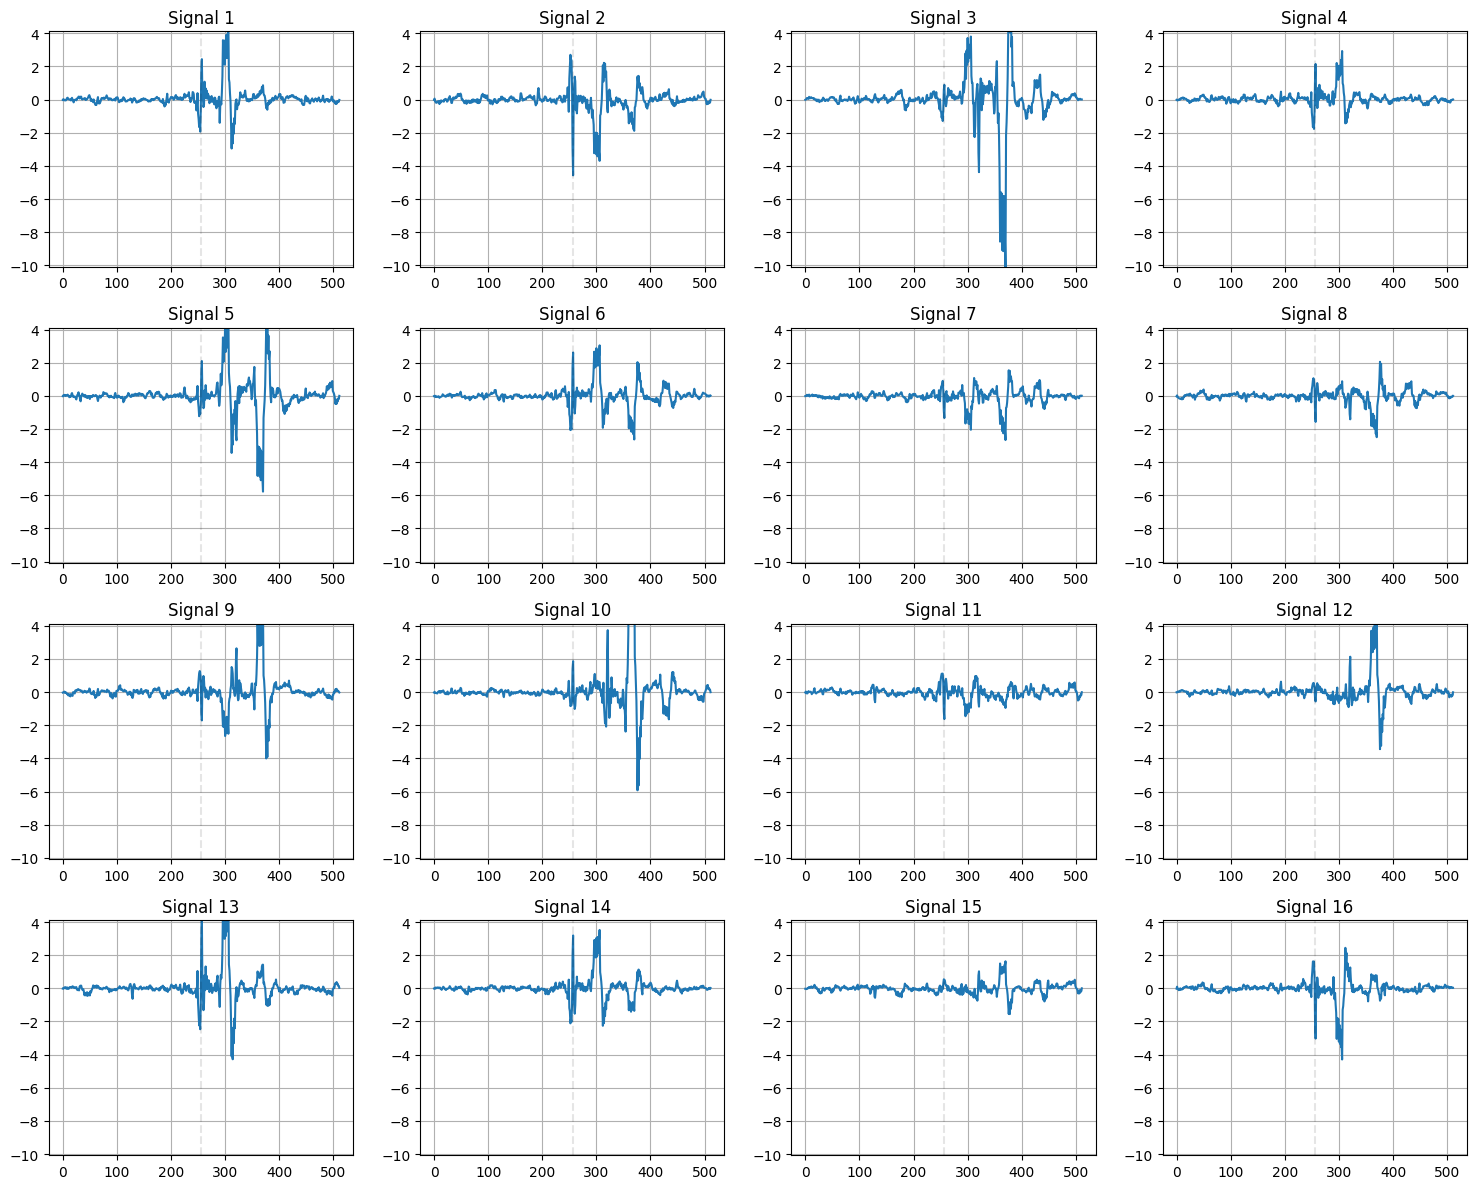

[22/32][0/111]	Loss_D: 0.7173	Loss_G: 2.1450	D(x): 0.1579	D(G(z)): 0.7870 / 0.7152
[22/32][50/111]	Loss_D: 0.4238	Loss_G: 2.0158	D(x): 0.0999	D(G(z)): 0.6299 / 0.7271
[22/32][100/111]	Loss_D: 0.7248	Loss_G: 1.3635	D(x): 0.1416	D(G(z)): 0.5646 / 0.6233


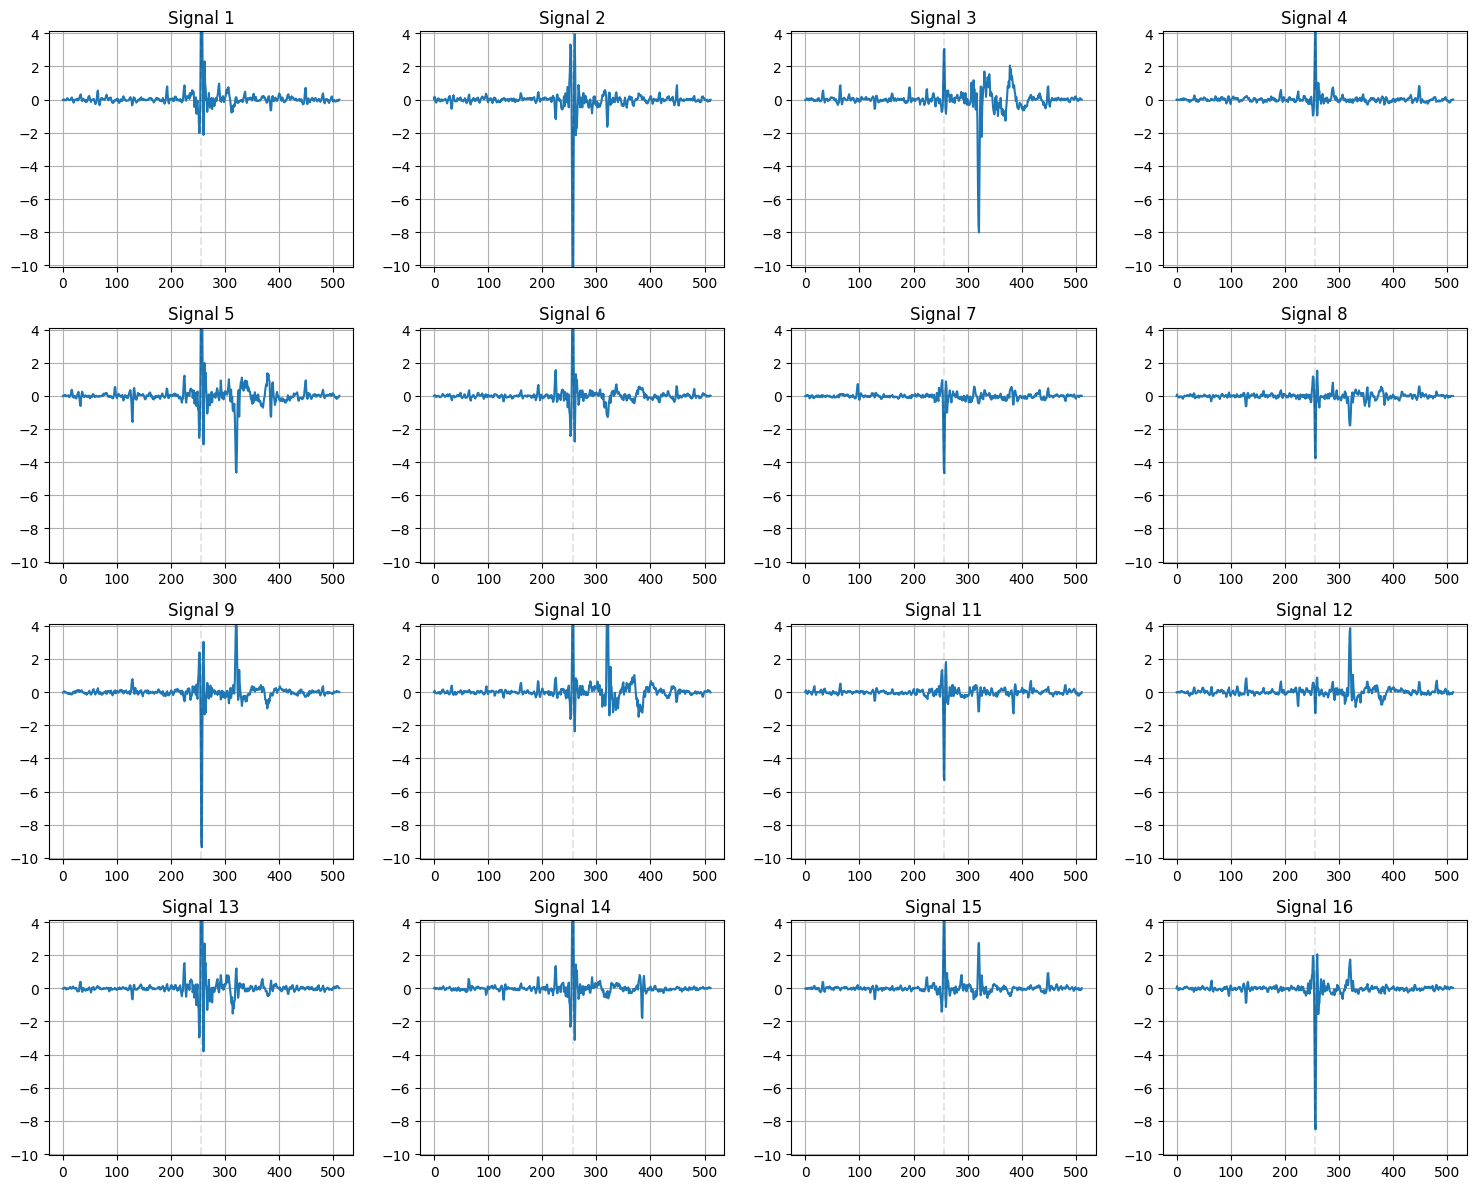

[23/32][0/111]	Loss_D: 1.1032	Loss_G: 2.0980	D(x): 0.1253	D(G(z)): 0.6145 / 0.7227
[23/32][50/111]	Loss_D: 0.9310	Loss_G: 1.9000	D(x): 0.1743	D(G(z)): 0.7680 / 0.7105
[23/32][100/111]	Loss_D: 0.4615	Loss_G: 2.2535	D(x): 0.1106	D(G(z)): 0.6995 / 0.7595


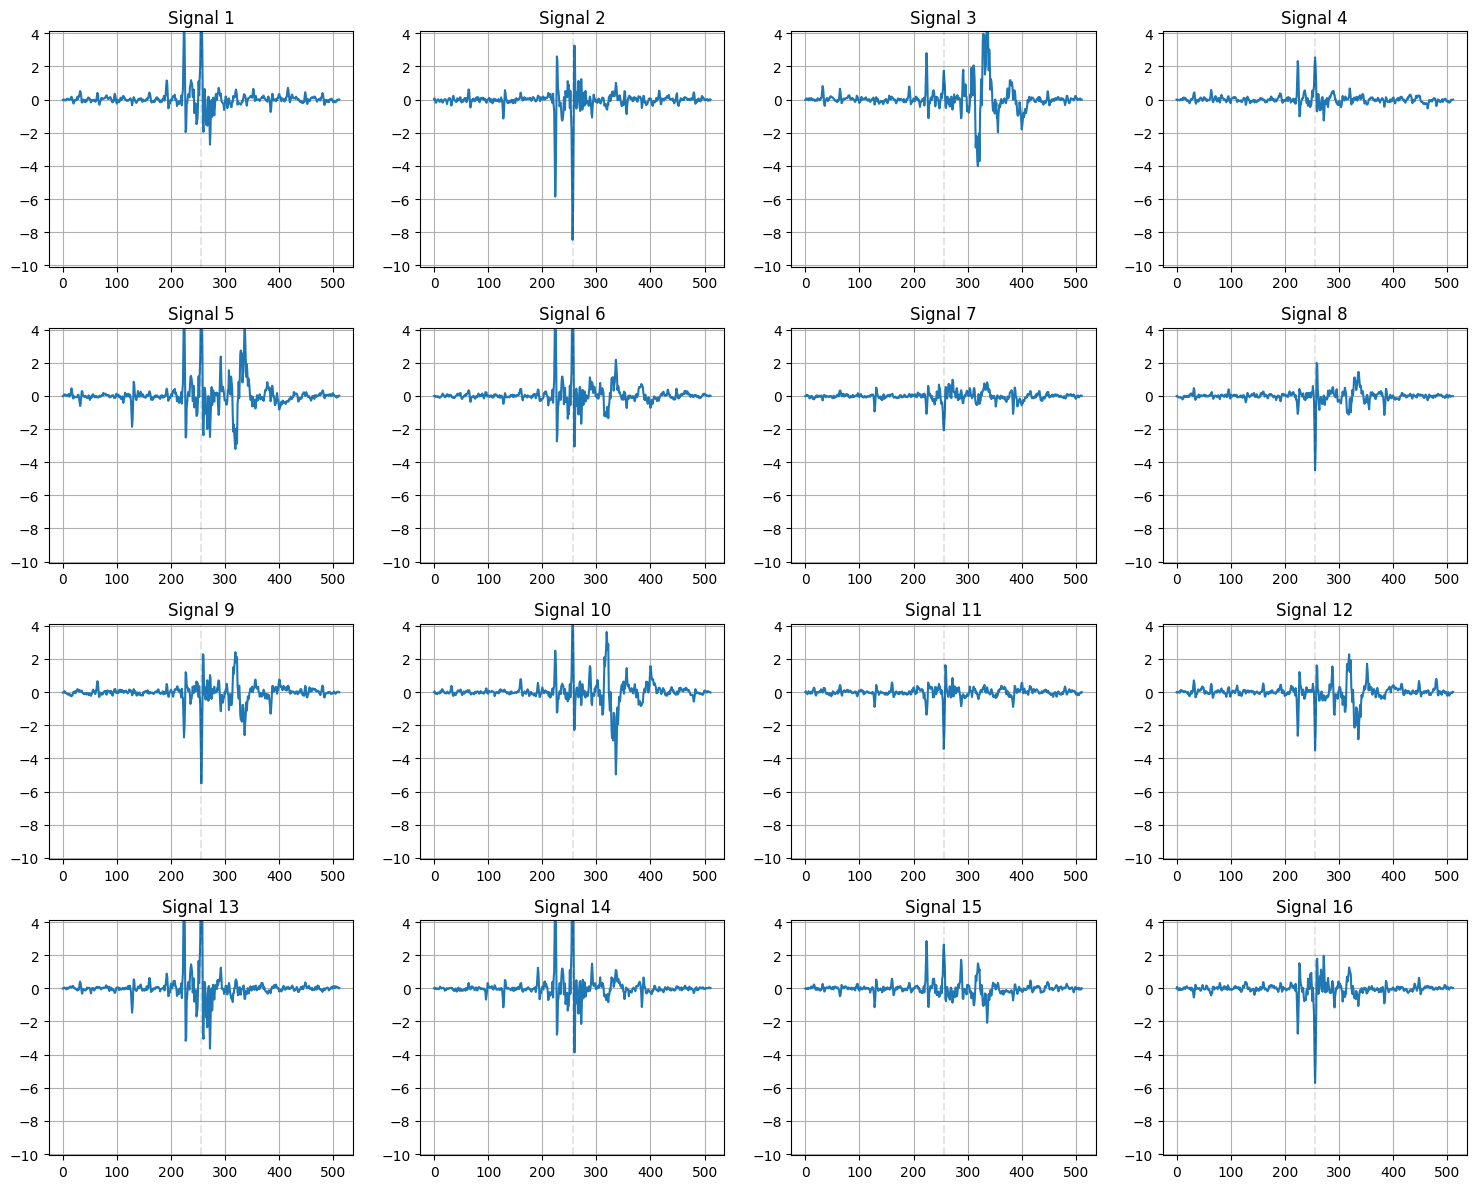

[24/32][0/111]	Loss_D: 0.6078	Loss_G: 1.5318	D(x): 0.0658	D(G(z)): 0.6769 / 0.6295
[24/32][50/111]	Loss_D: 1.0513	Loss_G: 2.4085	D(x): 0.1795	D(G(z)): 0.6316 / 0.7452
[24/32][100/111]	Loss_D: 1.2223	Loss_G: 2.6076	D(x): 0.1570	D(G(z)): 0.7606 / 0.7538


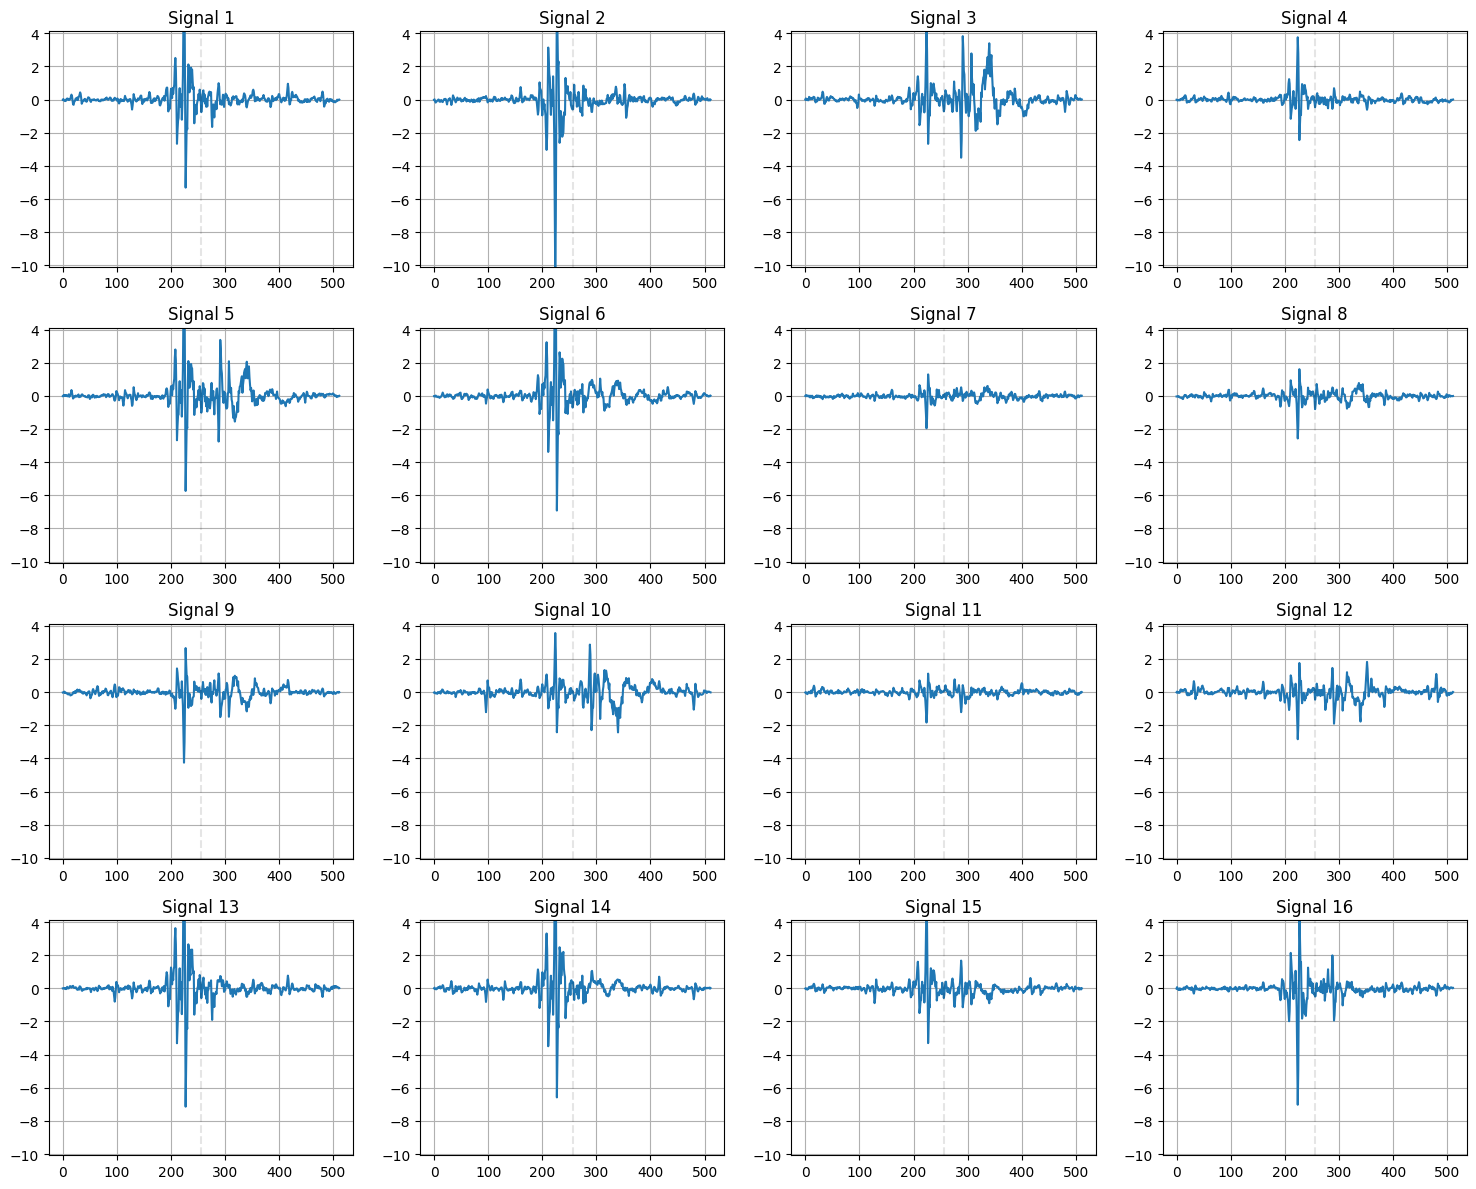

[25/32][0/111]	Loss_D: 1.0379	Loss_G: 1.8657	D(x): 0.1569	D(G(z)): 0.6995 / 0.7056
[25/32][50/111]	Loss_D: 0.5566	Loss_G: 3.6371	D(x): 0.1575	D(G(z)): 0.8183 / 0.8258
[25/32][100/111]	Loss_D: 0.6111	Loss_G: 2.6089	D(x): 0.1111	D(G(z)): 0.6790 / 0.7285


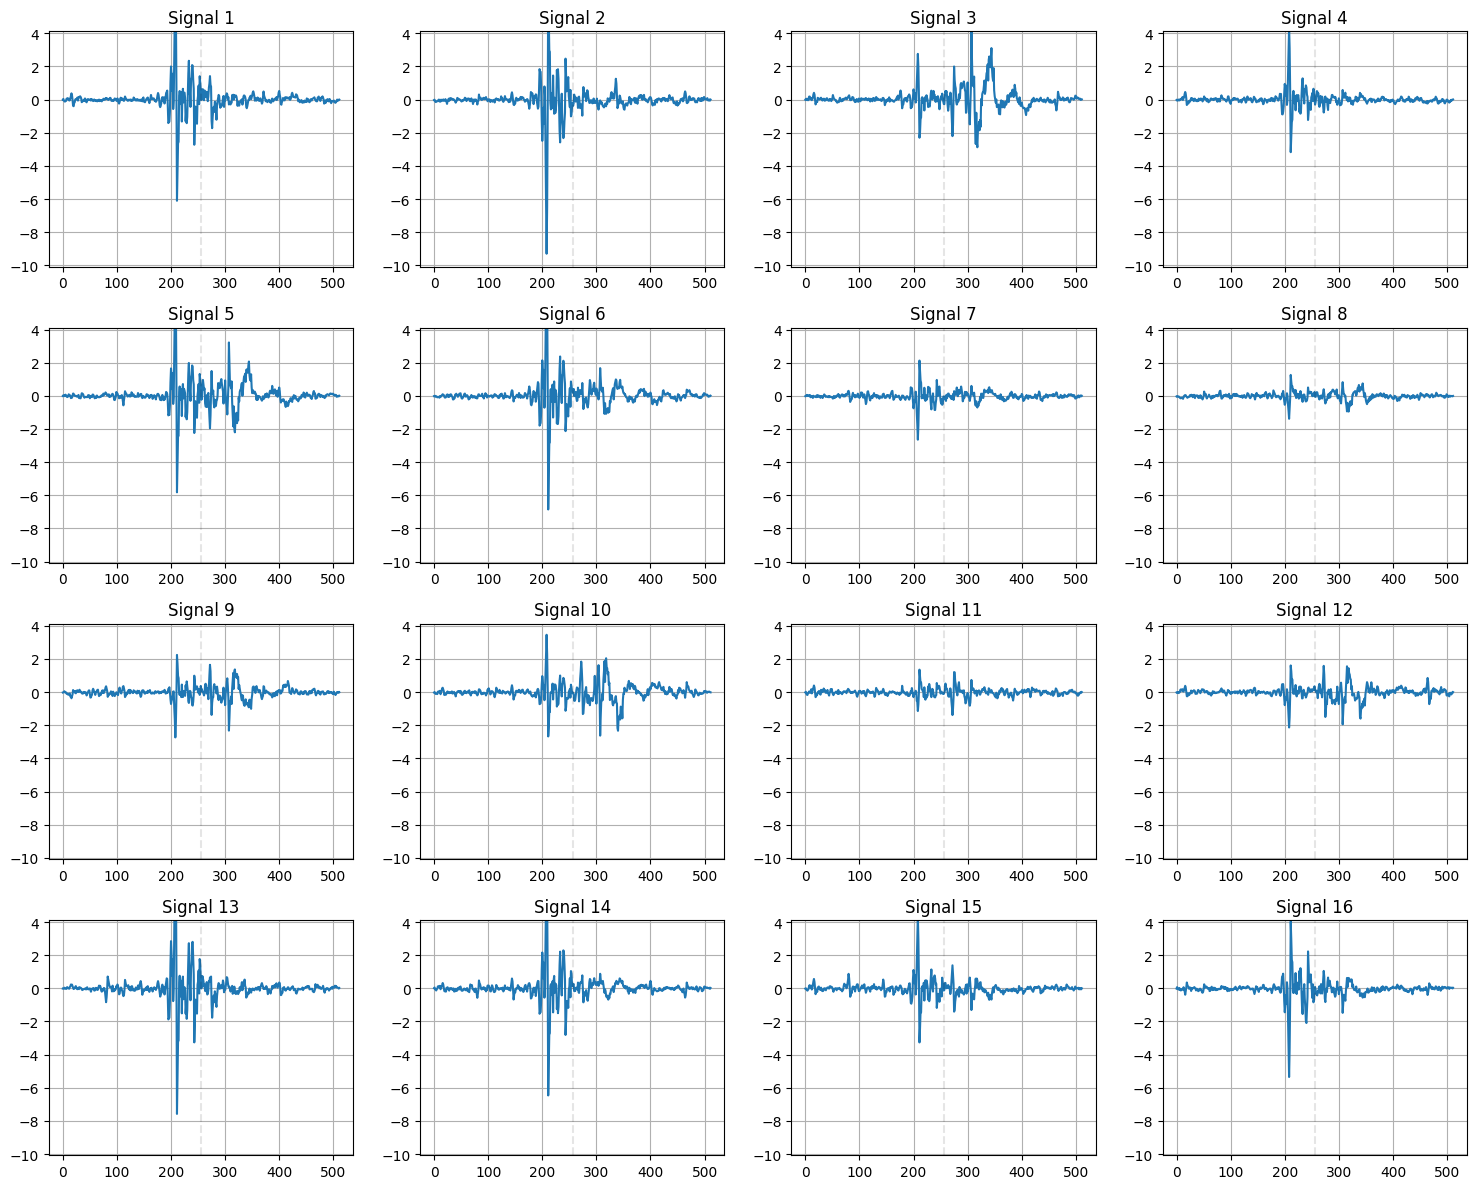

[26/32][0/111]	Loss_D: 0.8157	Loss_G: 2.2349	D(x): 0.1490	D(G(z)): 0.7965 / 0.7586
[26/32][50/111]	Loss_D: 0.9607	Loss_G: 3.0380	D(x): 0.2052	D(G(z)): 0.8089 / 0.8082
[26/32][100/111]	Loss_D: 0.6788	Loss_G: 1.9925	D(x): 0.1584	D(G(z)): 0.7168 / 0.7268


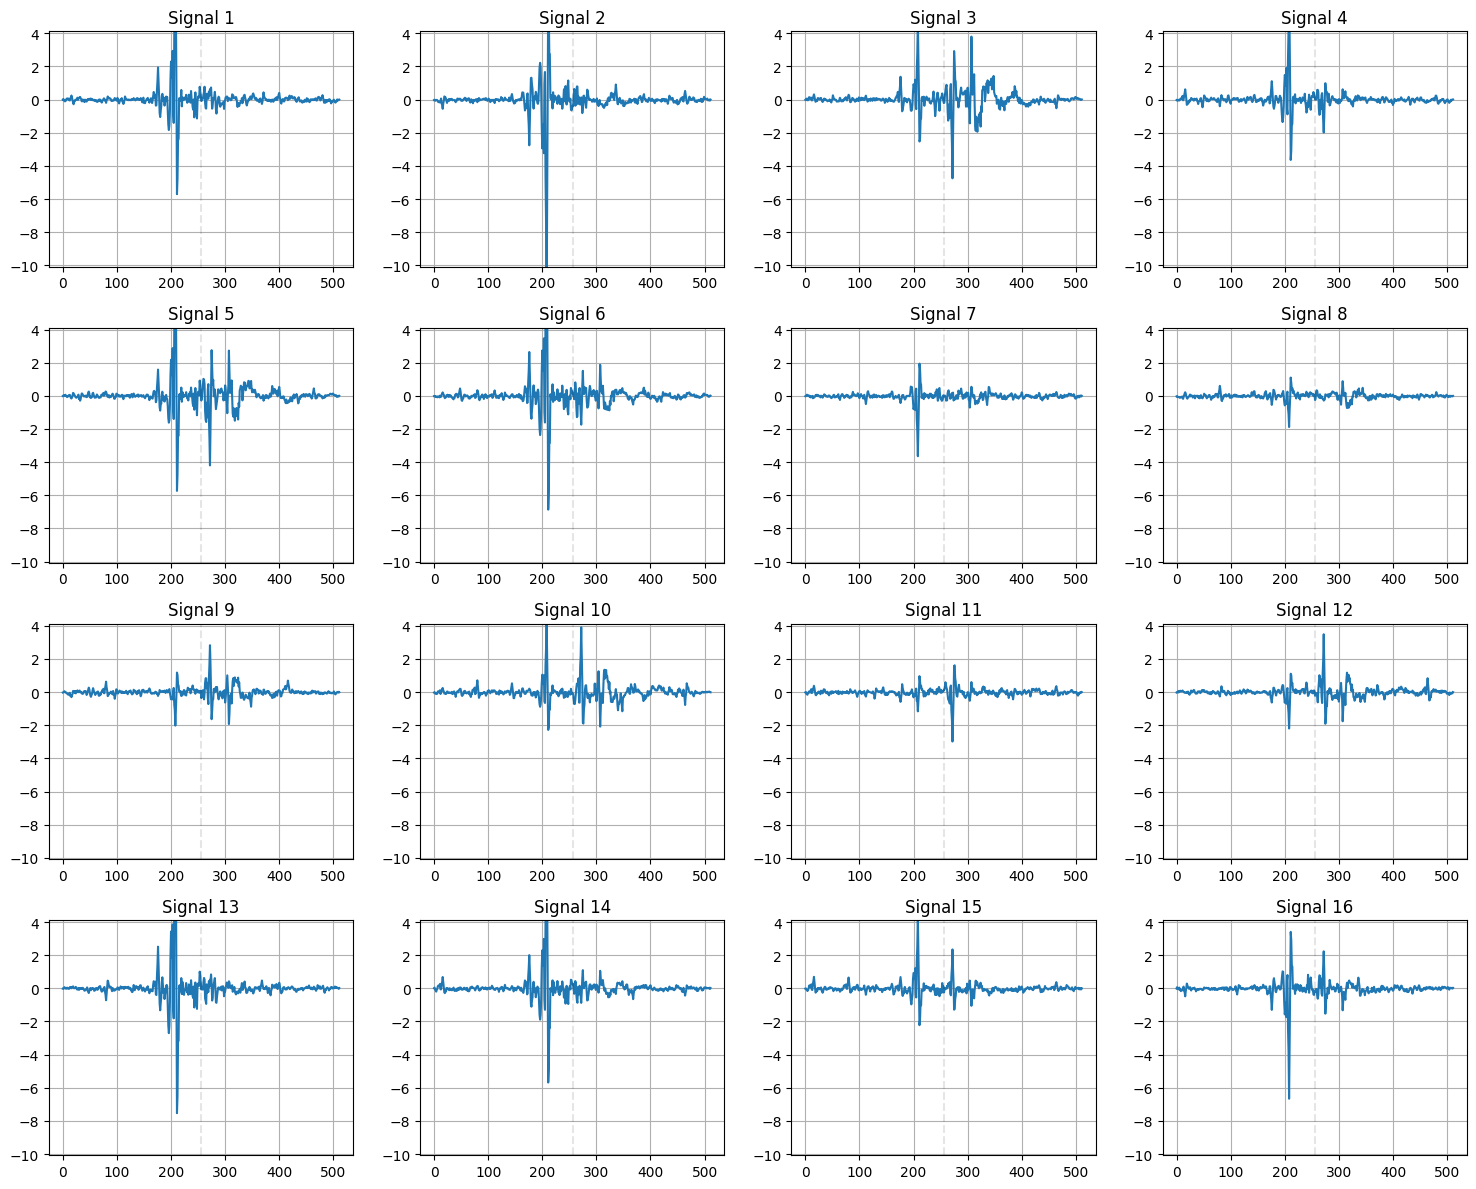

[27/32][0/111]	Loss_D: 0.9473	Loss_G: 2.1075	D(x): 0.1412	D(G(z)): 0.7447 / 0.7163
[27/32][50/111]	Loss_D: 0.8410	Loss_G: 2.5376	D(x): 0.1464	D(G(z)): 0.7946 / 0.7288
[27/32][100/111]	Loss_D: 0.8495	Loss_G: 2.8926	D(x): 0.1504	D(G(z)): 0.7951 / 0.8411


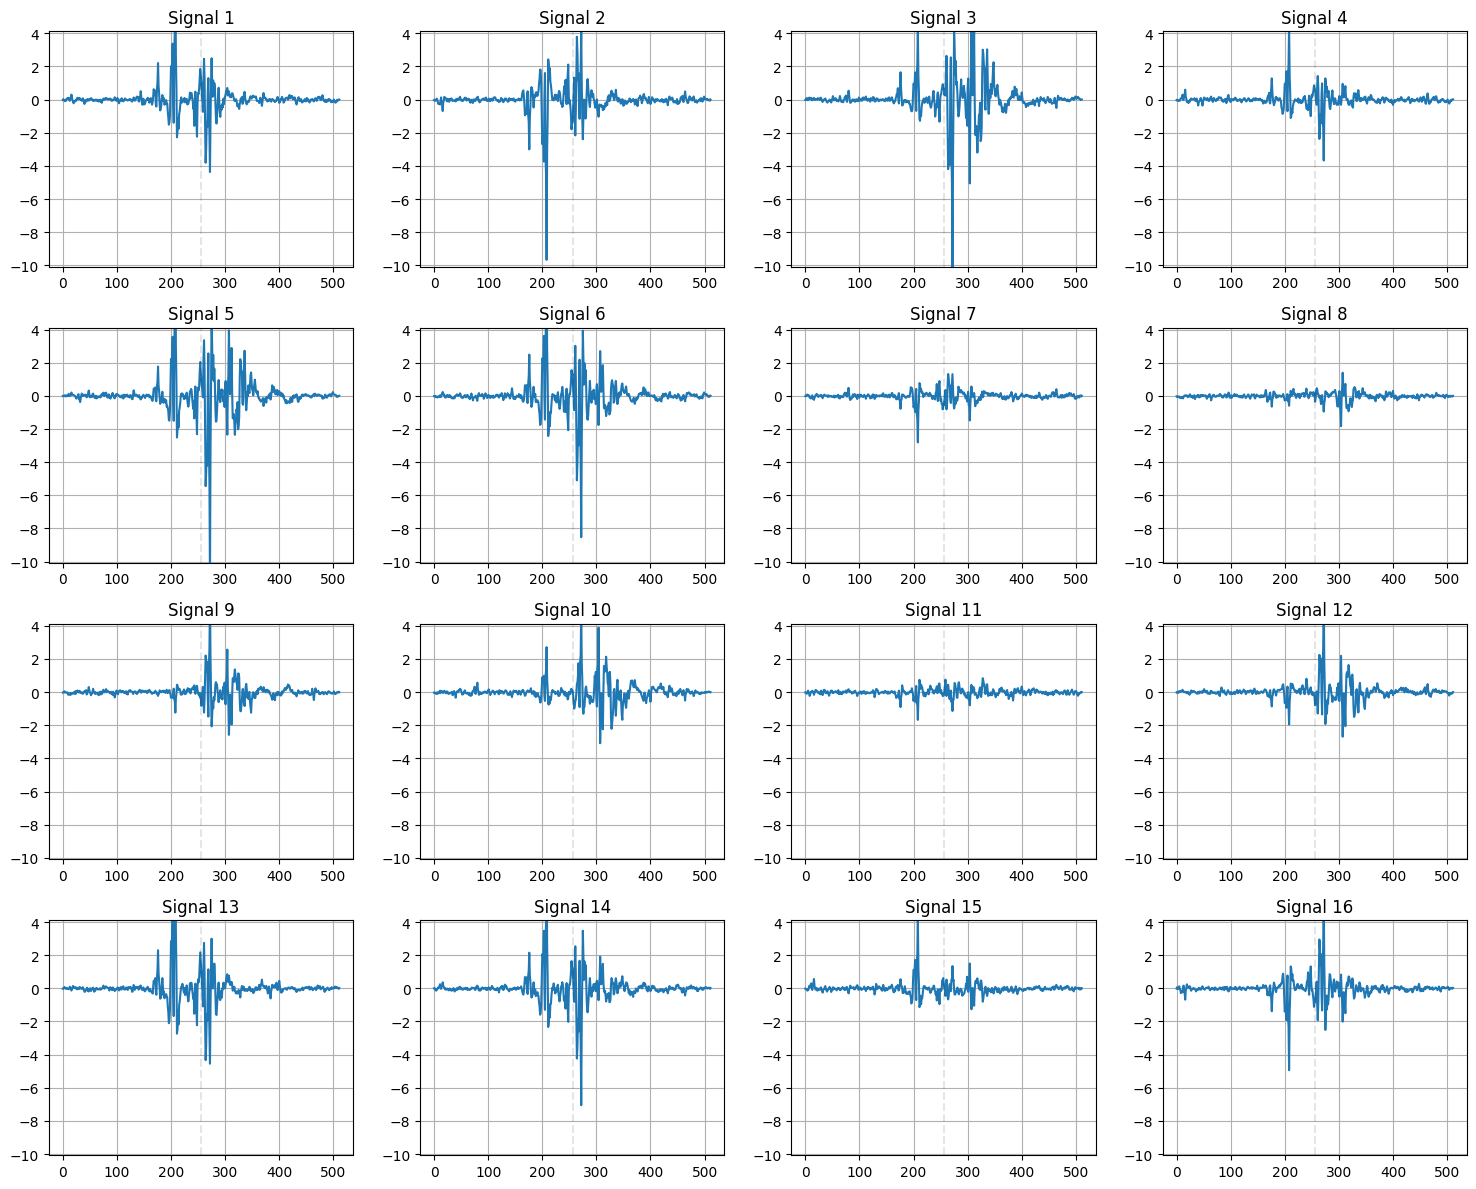

[28/32][0/111]	Loss_D: 0.8570	Loss_G: 1.5242	D(x): 0.1593	D(G(z)): 0.6944 / 0.6467
[28/32][50/111]	Loss_D: 1.0610	Loss_G: 3.3043	D(x): 0.1154	D(G(z)): 0.8108 / 0.8881
[28/32][100/111]	Loss_D: 0.8256	Loss_G: 3.1315	D(x): 0.1795	D(G(z)): 0.7976 / 0.8219


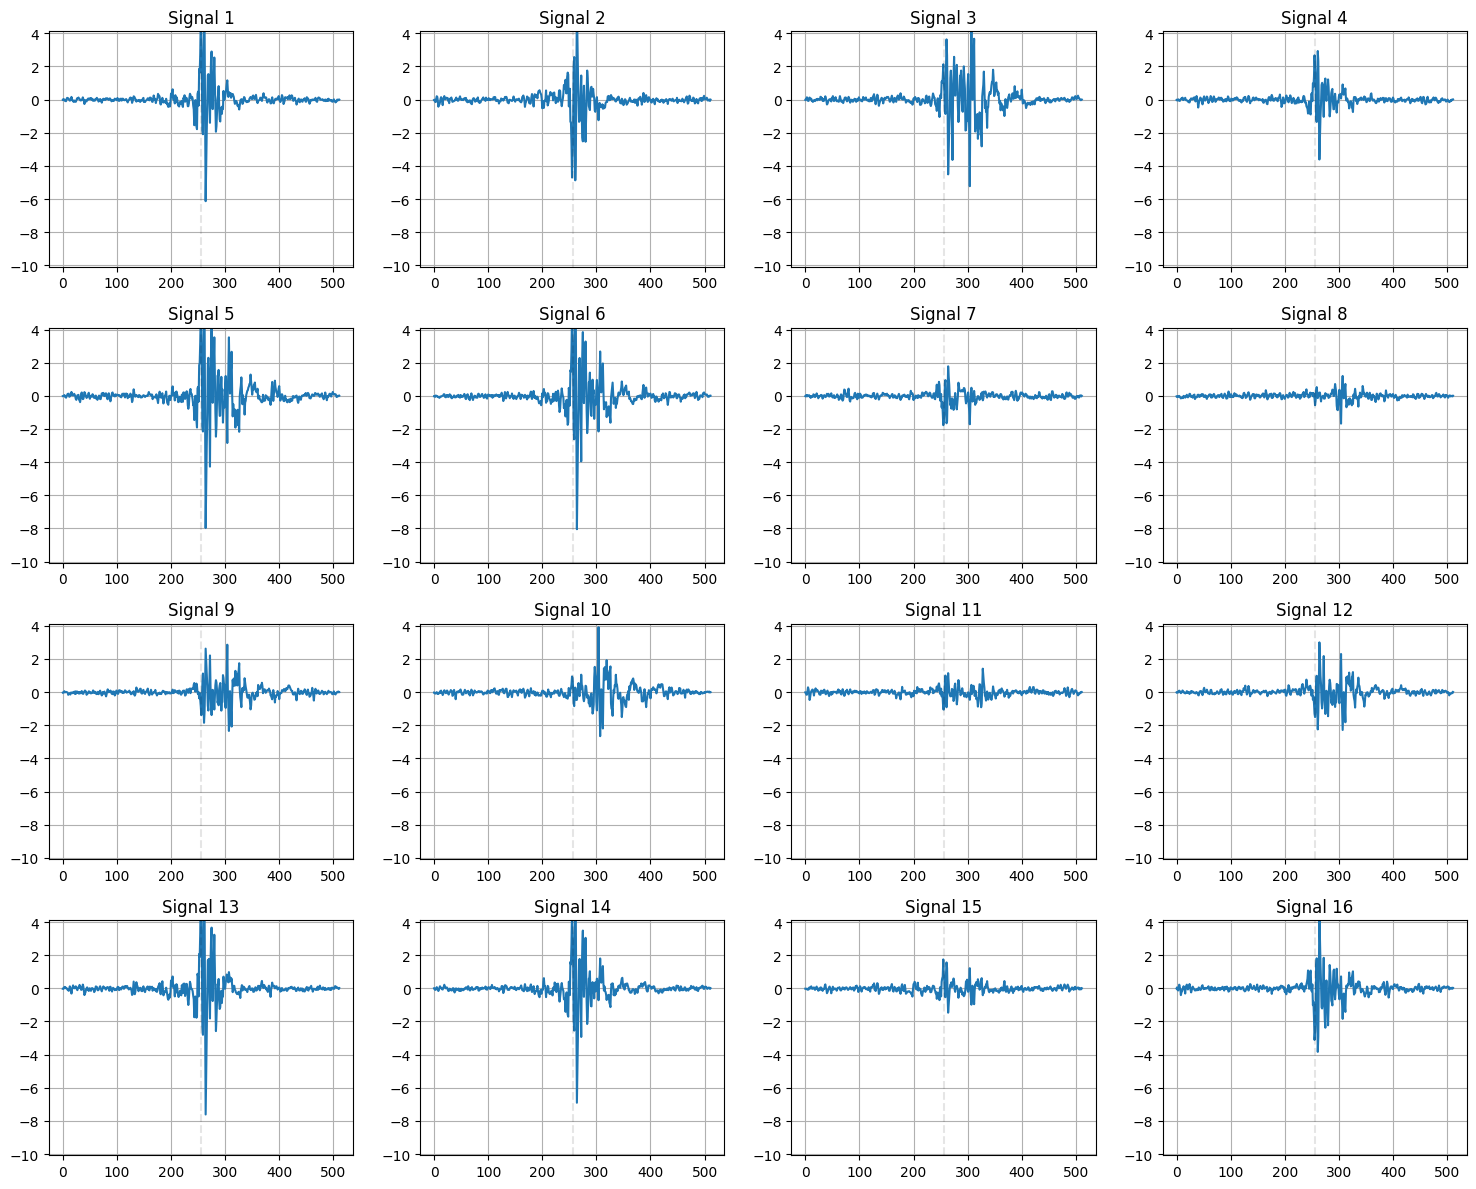

[29/32][0/111]	Loss_D: 0.9756	Loss_G: 3.3323	D(x): 0.1626	D(G(z)): 0.8355 / 0.7974
[29/32][50/111]	Loss_D: 0.7684	Loss_G: 3.1582	D(x): 0.1745	D(G(z)): 0.8487 / 0.8021
[29/32][100/111]	Loss_D: 1.7570	Loss_G: 5.5085	D(x): 0.1630	D(G(z)): 0.8726 / 0.9300


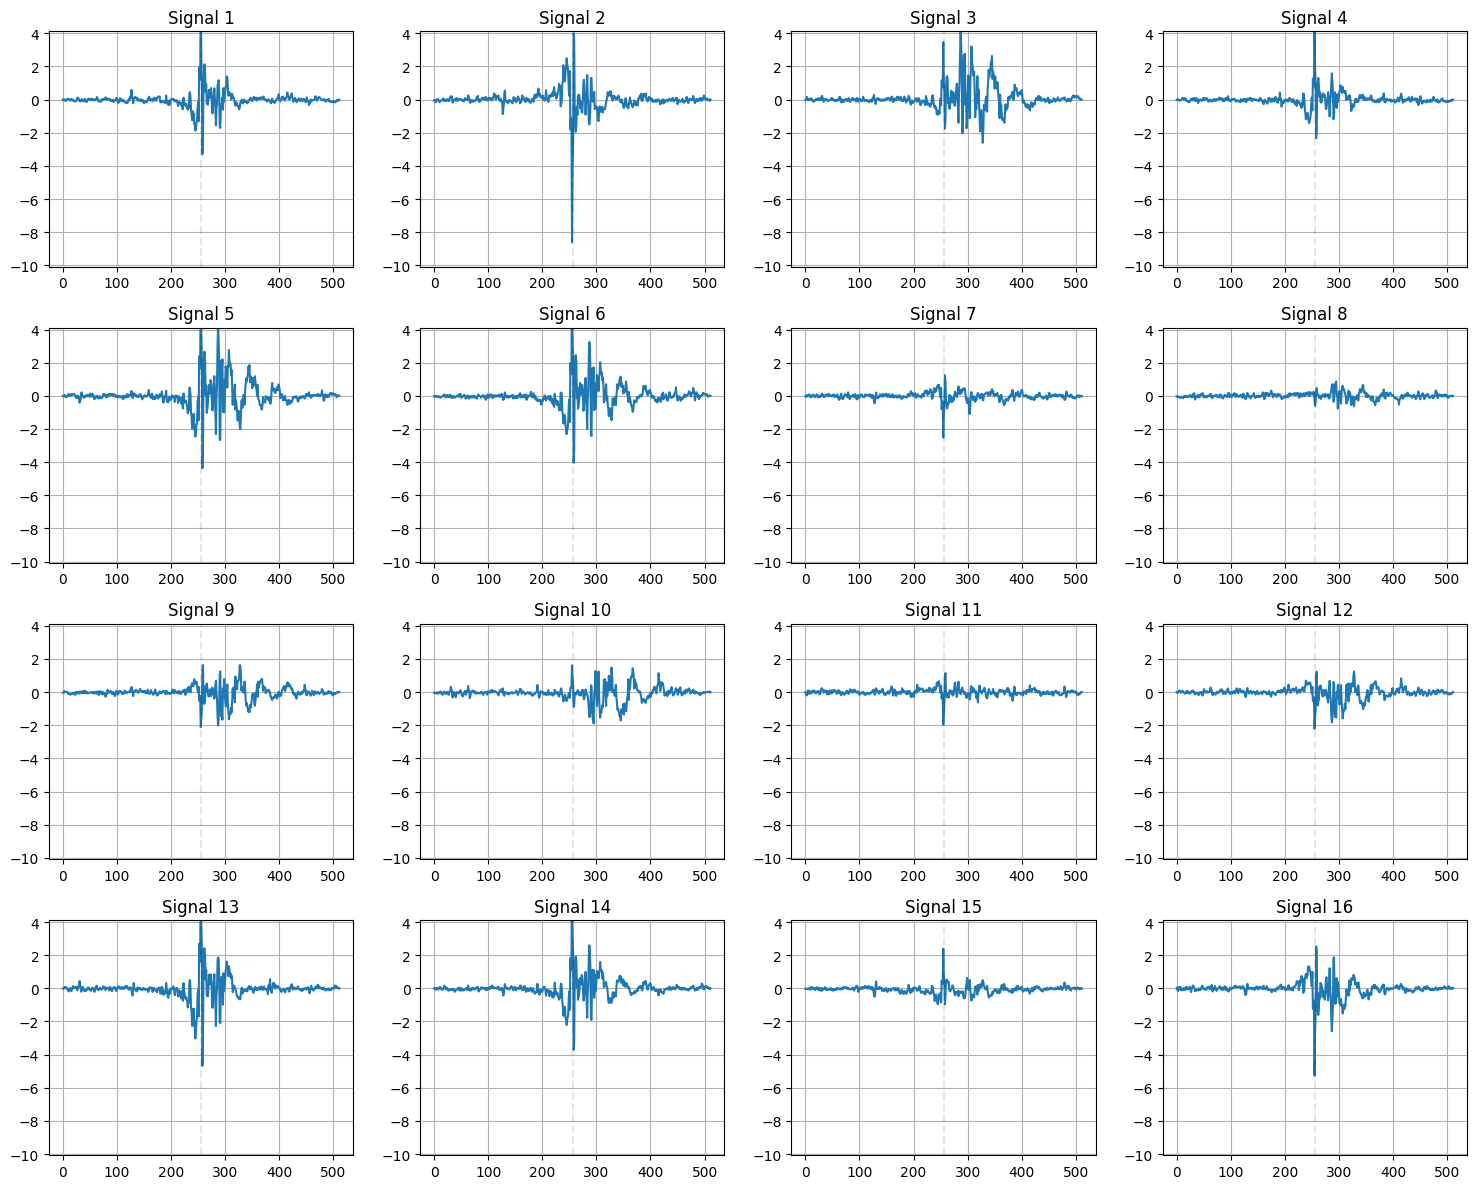

[30/32][0/111]	Loss_D: 0.8055	Loss_G: 1.0790	D(x): 0.0789	D(G(z)): 0.4521 / 0.5578
[30/32][50/111]	Loss_D: 0.7049	Loss_G: 2.5518	D(x): 0.1752	D(G(z)): 0.8526 / 0.7629
[30/32][100/111]	Loss_D: 0.7606	Loss_G: 2.9255	D(x): 0.1311	D(G(z)): 0.8521 / 0.8126


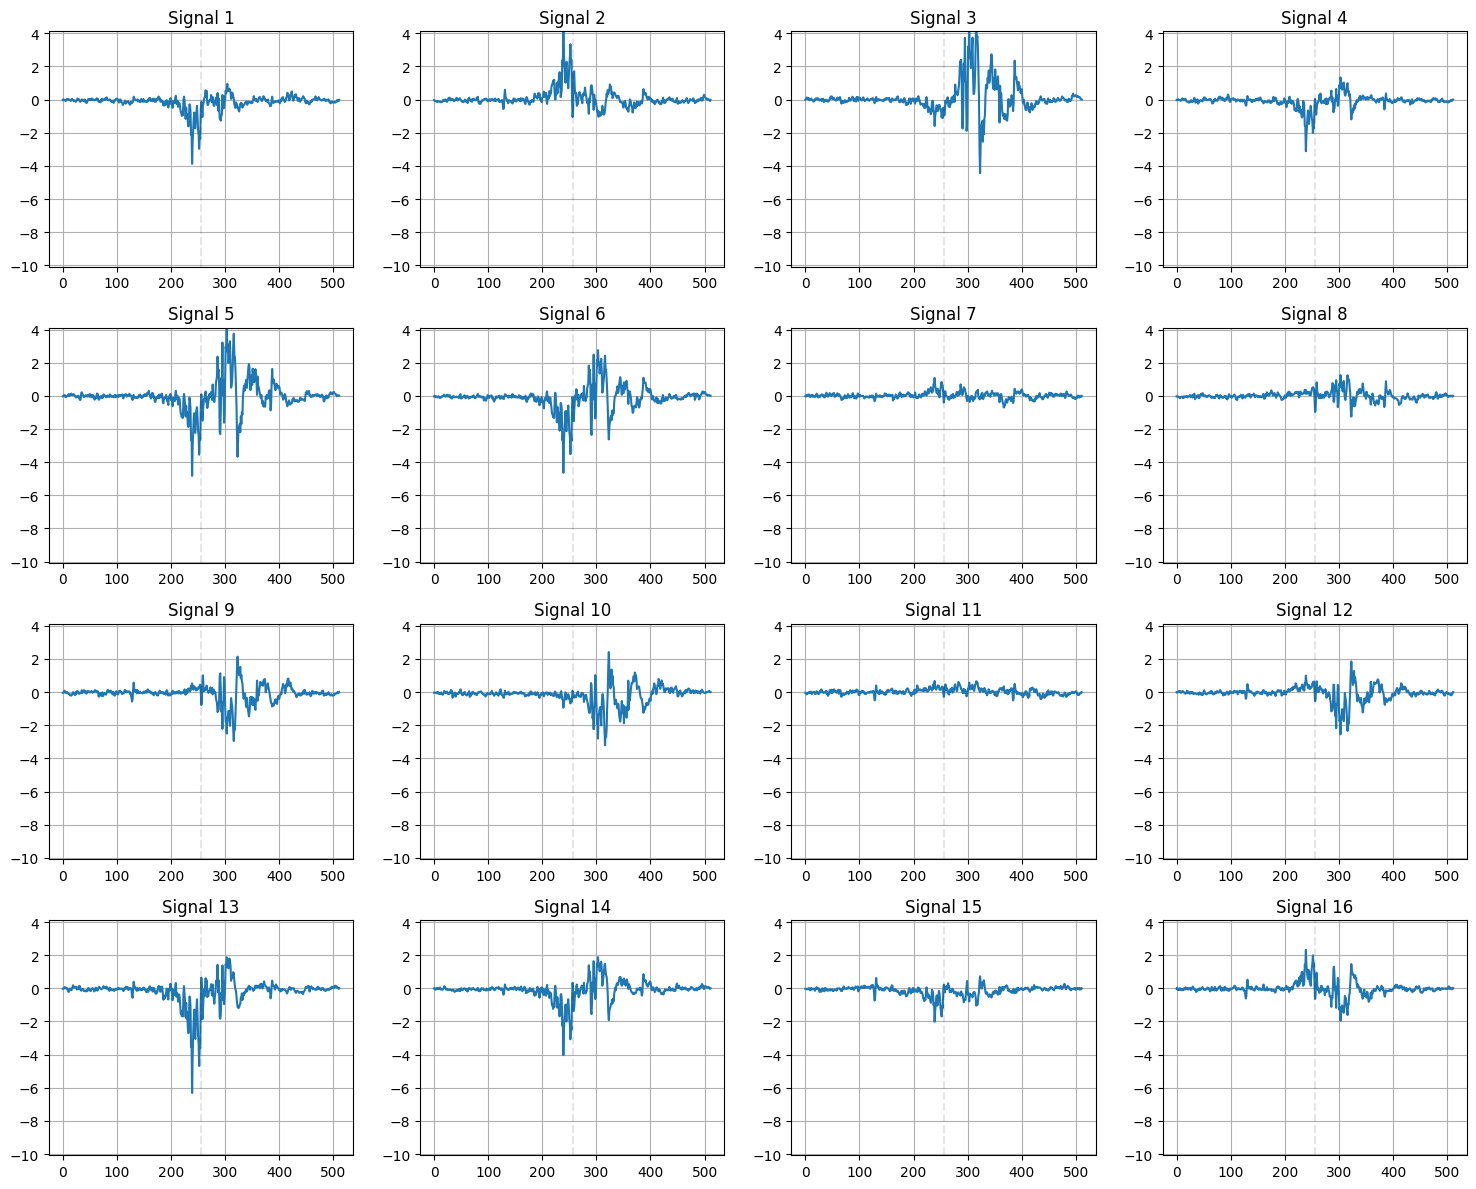

[31/32][0/111]	Loss_D: 0.8506	Loss_G: 2.2187	D(x): 0.1466	D(G(z)): 0.8553 / 0.7576
[31/32][50/111]	Loss_D: 1.3320	Loss_G: 2.6016	D(x): 0.1787	D(G(z)): 0.4117 / 0.8121
[31/32][100/111]	Loss_D: 0.5910	Loss_G: 2.2981	D(x): 0.1328	D(G(z)): 0.8191 / 0.7501


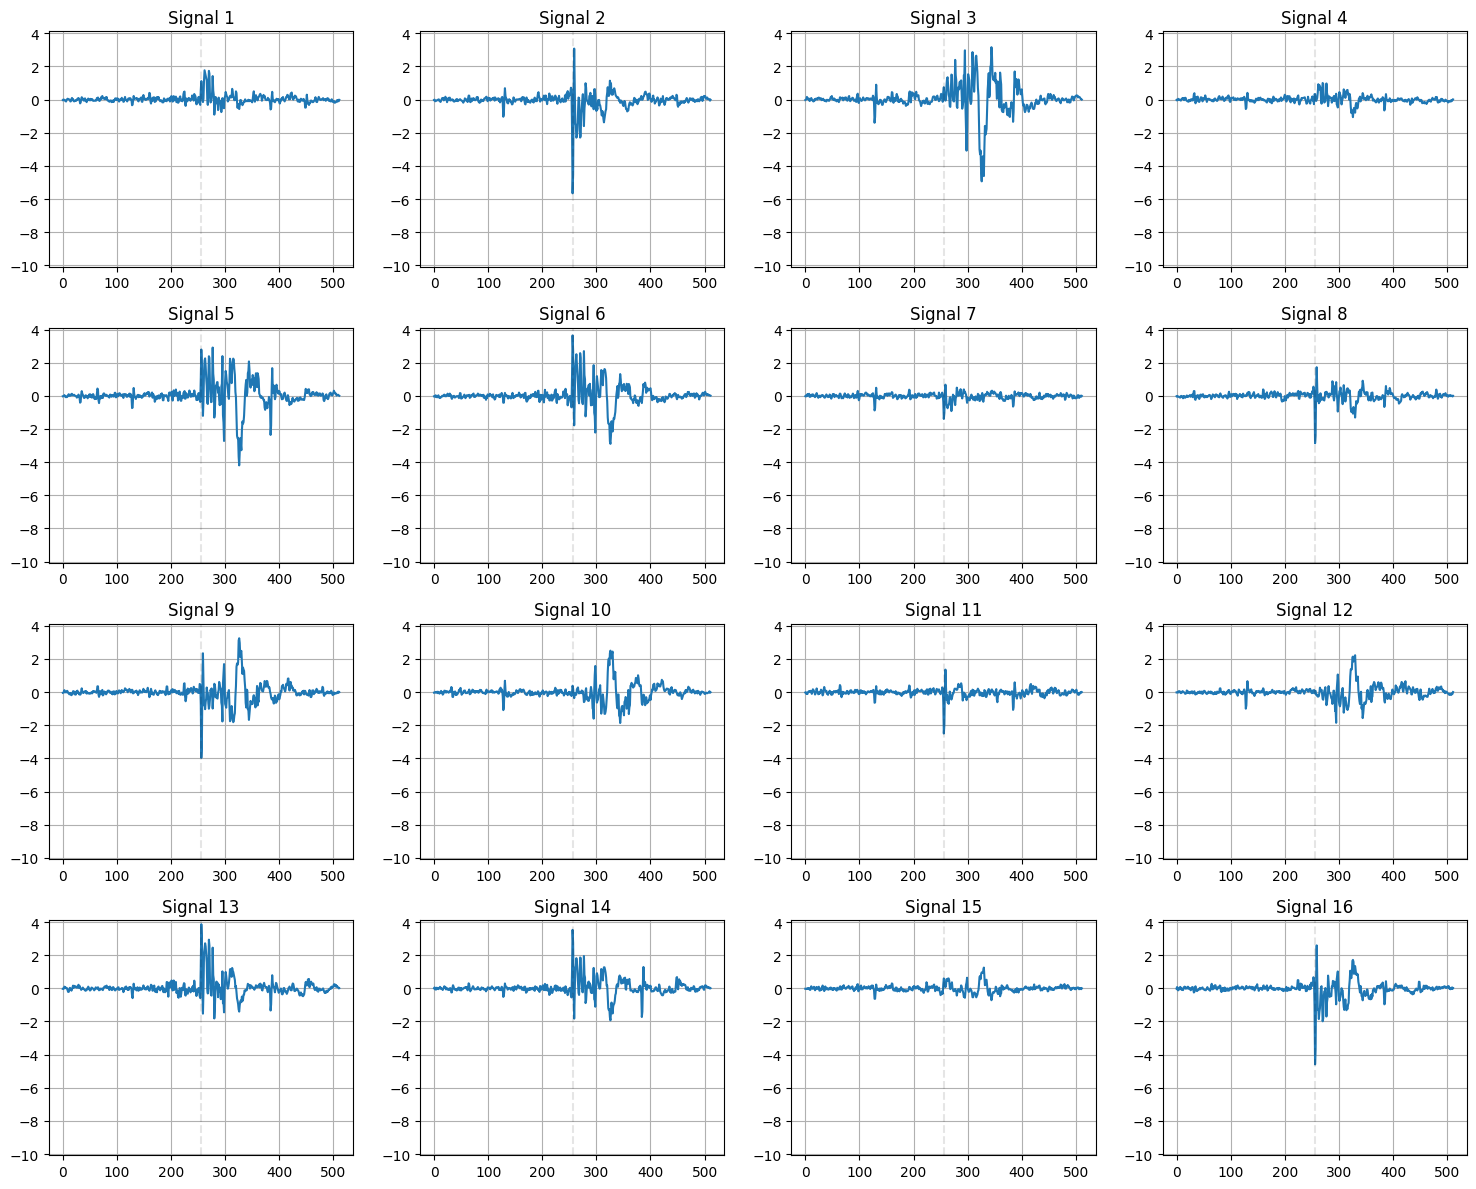

In [60]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 
    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()

    signal_list.append(fake_signals)

### Gradients

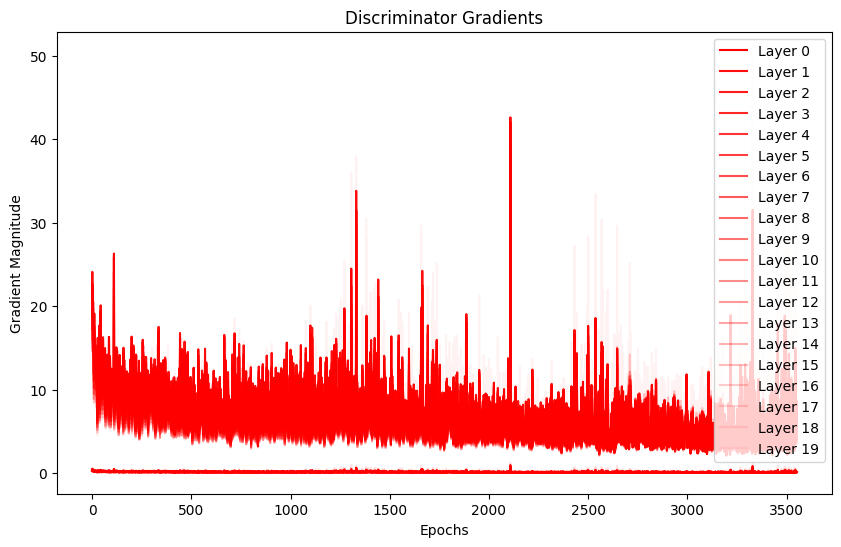

In [61]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

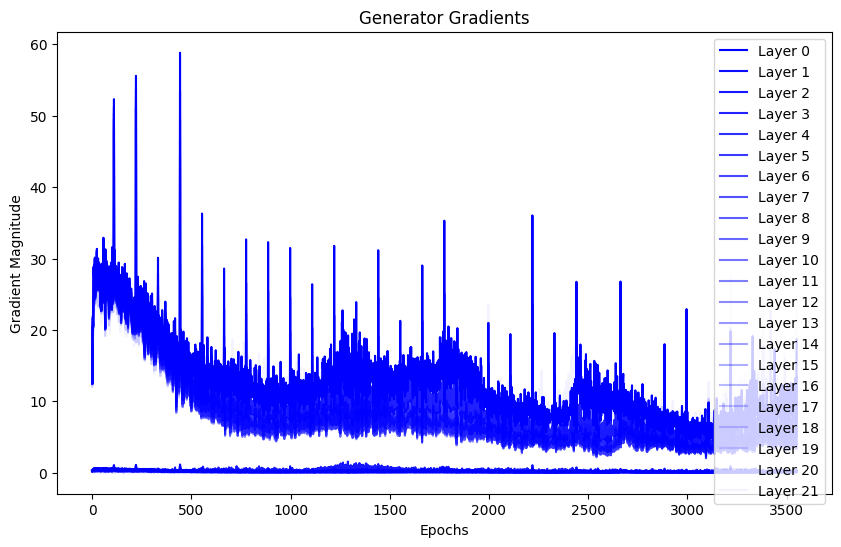

In [62]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

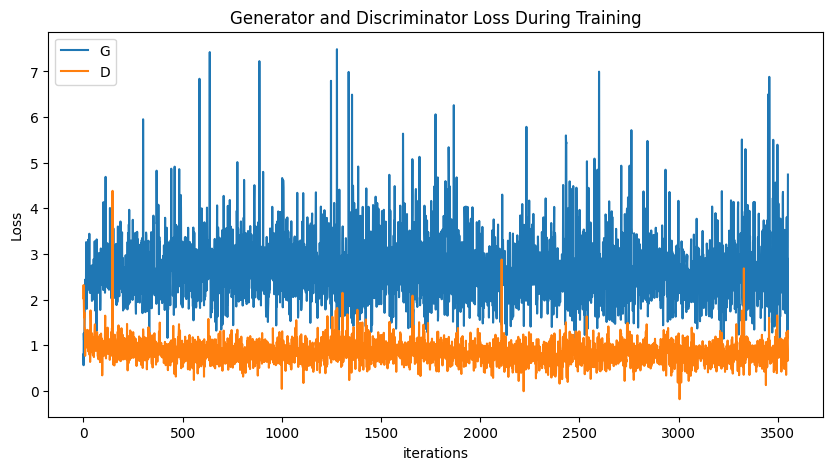

In [63]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


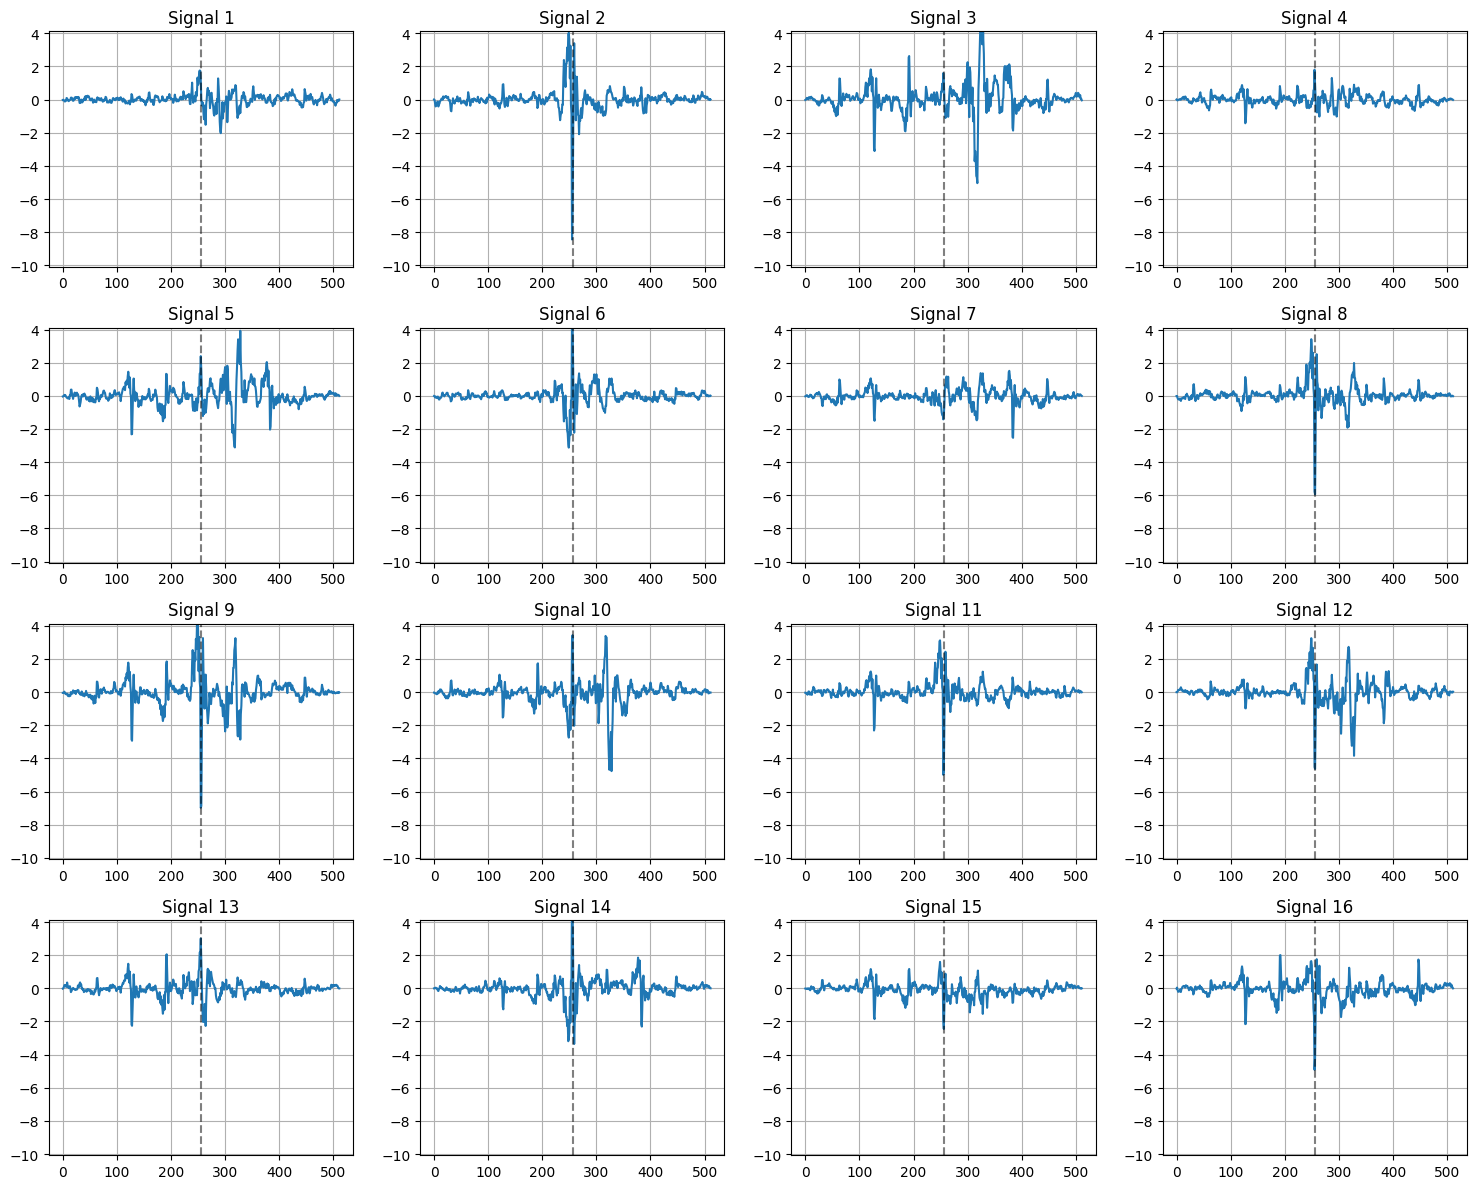

In [64]:
batch = signal_list[16]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [65]:
# # Path to the folder containing PNG images
# image_folder = '../data/gw-dcgans-images'

# # Get a list of image filenames in the folder
# image_filenames = sorted([filename for filename in os.listdir(image_folder) if filename.endswith('.png')])

# # Load images and create an animation
# def update(frame):
#     img_path = os.path.join(image_folder, image_filenames[frame])
#     img = Image.open(img_path)
    
#     # Clear the previous plot
#     plt.clf()
    
#     # Display the image without cropping and centered
#     plt.imshow(img, aspect='auto')
#     plt.axis('off')

# fig = plt.figure(figsize=(8, 8))

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_filenames), interval=1000, repeat_delay=1000)

# # Display the animation as HTML (for Jupyter Notebook) or save it to a file
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Save the animation as an .mp4 video
# output_filename = '../data/gw-dcgans-mp4/signals.mp4'
# ani.save(output_filename, writer='ffmpeg', codec='libx264', fps=8, dpi=100, bitrate=1800)

# print(f'Animation saved as {output_filename}')

In [66]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)
